# Entwicklung eines datenbasierten Modells zur Preisprognose gebrauchter Fahrzeuge
- Name: Meshalkin Artur
- Student-ID : 586811

# 1.Problemstellung
<p style="text-align: justify;">
Der Preis eines gebrauchten Autos wird von einer Vielzahl unterschiedlicher Faktoren beeinflusst. Für Käufer und Verkäufer ist es daher häufig schwierig, einen realistischen und fairen Marktpreis einzuschätzen.
</p>
<p style="text-align: justify;">
Ziel dieses Projekts ist es, ein datenbasiertes Vorhersagemodell zu entwickeln, das den Verkaufspreis eines gebrauchten Autos automatisch und möglichst präzise prognostiziert.
</p>


<img src="car.png" width="60%">




# [2.Datenbeschaffung](https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023)

In [2]:
#!curl -L -o ./cars-germany.zip https://www.kaggle.com/api/v1/datasets/download/wspirat/germany-used-cars-dataset-2023

In [3]:
#!unzip cars-germany.zip

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import plotly.express as px
%matplotlib inline

In [79]:
plt.rcParams.update({
    "figure.figsize": (12, 7),
    "font.size": 16,          
    "axes.titlesize": 20,   
    "axes.labelsize": 18,    
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "legend.title_fontsize": 18,
    "figure.titlesize": 22
})

In [6]:
data = pd.read_csv("data.csv")
data[3000:].head(2).T

,3000,3001
Unnamed: 0,3000,3001
brand,audi,audi
model,Audi TT,Audi A3
color,black,black
registration_date,12/2006,04/2006
year,2006,2006
price_in_euro,13500,6800
power_kw,147,147
power_ps,200,200
transmission_type,Manual,Manual


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                251079 non-null  int64  
 1   brand                     251079 non-null  object 
 2   model                     251079 non-null  object 
 3   color                     250913 non-null  object 
 4   registration_date         251075 non-null  object 
 5   year                      251079 non-null  object 
 6   price_in_euro             251079 non-null  object 
 7   power_kw                  250945 non-null  object 
 8   power_ps                  250950 non-null  object 
 9   transmission_type         251079 non-null  object 
 10  fuel_type                 251079 non-null  object 
 11  fuel_consumption_l_100km  224206 non-null  object 
 12  fuel_consumption_g_km     251079 non-null  object 
 13  mileage_in_km             250927 non-null  f

* man kann sehen, dass die meisten Daten als object vorgegeben sind. Bringen wir sie ins richtige Format.

# 3.Explorative Datenanalyse

## Konvertierung der Daten ins richtige Format

In [8]:
data = data.drop(columns=["Unnamed: 0"])
data["registration_date"] = pd.to_datetime(data["registration_date"], errors="coerce",format="%m/%Y")
data["year"] = pd.to_datetime(data["year"],errors="coerce",format="%Y")
float_cols = ["price_in_euro","power_kw","power_ps"]
data[float_cols] = data[float_cols].apply(pd.to_numeric, errors="coerce")
data[float_cols] = data[float_cols].astype("float64") 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   brand                     251079 non-null  object        
 1   model                     251079 non-null  object        
 2   color                     250913 non-null  object        
 3   registration_date         250880 non-null  datetime64[ns]
 4   year                      250880 non-null  datetime64[ns]
 5   price_in_euro             250880 non-null  float64       
 6   power_kw                  250786 non-null  float64       
 7   power_ps                  250869 non-null  float64       
 8   transmission_type         251079 non-null  object        
 9   fuel_type                 251079 non-null  object        
 10  fuel_consumption_l_100km  224206 non-null  object        
 11  fuel_consumption_g_km     251079 non-null  object        
 12  mi

In [9]:
nan_counts = data.isna().groupby(data["fuel_type"])["fuel_consumption_l_100km"].sum()

total_counts = data.groupby("fuel_type")["fuel_consumption_l_100km"].count() + nan_counts

summary = pd.DataFrame({
    "NaN_count": nan_counts,
    "Total_count": total_counts
})

summary.sort_values(by="NaN_count", ascending=False).head(10)


,NaN_count,Total_count
fuel_type,,
Petrol,11104,143280
Diesel,7425,86421
Electric,5496,5967
Hybrid,2257,12607
LPG,185,1255
Diesel Hybrid,99,476
CNG,94,508
Other,91,178
Unknown,73,96


- Die elektrische Autos  haben großen Anteil an Null Werten für fuel_consumption_l_100km und für fuel_consumption_g_km anderen Standard als g/km
- Erstmal ersetzen wir die fuel_consumption_g_km durhc  Null Werte

In [10]:
data[(data["fuel_type"] == "Electric") & (~data["fuel_consumption_l_100km"].isna())].head(5)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
19048,audi,Audi e-tron,red,2020-11-01,2020-01-01,62990.0,300.0,408.0,Automatic,Electric,430 km (Ort),391 km Reichweite,7924.0,55 adv.+S-line quattro PANO/B&O/MATRIX/20
20561,audi,Audi Q4 e-tron,blue,2022-03-01,2022-01-01,47699.0,125.0,170.0,Automatic,Electric,455 km (Ort),327 km Reichweite,9950.0,Sportback 35 E-TRON MATRIX-LED*ASSISTENZ-PAKET...
20577,audi,Audi Q4 e-tron,blue,2022-03-01,2022-01-01,47499.0,125.0,170.0,Automatic,Electric,455 km (Ort),327 km Reichweite,9950.0,Sportback 35 E-TRON MATRIX-LED*ASSISTENZ-PAKET...
21245,audi,Audi Q4 e-tron,black,2022-10-01,2022-01-01,58850.0,220.0,299.0,Automatic,Electric,599 km (Ort),484 km Reichweite,7550.0,"Q4 Sportback 50 e-tron quattro*2xS-line,21"",ACC*"
21246,audi,Audi 50,black,2022-08-01,2022-01-01,61790.0,77.0,105.0,Automatic,Electric,0 kWh/100 km,0 g/km,13000.0,e-tron


In [11]:
data.head(5)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,alfa-romeo,Alfa Romeo GTV,red,1995-10-01,1995-01-01,1300.0,148.0,201.0,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.0,2.0 V6 TB
1,alfa-romeo,Alfa Romeo 164,black,1995-02-01,1995-01-01,24900.0,191.0,260.0,Manual,Petrol,NaN,- (g/km),190000.0,"Q4 Allrad, 3.2L GTA"
2,alfa-romeo,Alfa Romeo Spider,black,1995-02-01,1995-01-01,5900.0,110.0,150.0,Unknown,Petrol,NaN,- (g/km),129000.0,ALFA ROME 916
3,alfa-romeo,Alfa Romeo Spider,black,1995-07-01,1995-01-01,4900.0,110.0,150.0,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.0,2.0 16V Twin Spark L
4,alfa-romeo,Alfa Romeo 164,red,1996-11-01,1996-01-01,17950.0,132.0,179.0,Manual,Petrol,"7,2 l/100 km",- (g/km),96127.0,"3.0i Super V6, absoluter Topzustand !"


In [12]:
data["fuel_consumption_l_100km"] = data["fuel_consumption_l_100km"].str.extract(r"([\d.,]+)\s*l/100\s*km")
data["fuel_consumption_l_100km"] = data["fuel_consumption_l_100km"].str.replace(",", ".", regex=False).astype(float)

data["fuel_consumption_g_km"] = data["fuel_consumption_g_km"].str.extract(r"([\d,.]+)\s*g/km")

data["fuel_consumption_g_km"] = (
    data["fuel_consumption_g_km"]
    .str.replace(r"\.(?=\d{3})", "", regex=True)  
    .str.replace(",", ".", regex=False)          
    .astype(float)
)
data[["fuel_type","fuel_consumption_l_100km","fuel_consumption_g_km"]].head()

,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km
0,Petrol,10.9,260.0
1,Petrol,NaN,NaN
2,Petrol,NaN,NaN
3,Petrol,9.5,225.0
4,Petrol,7.2,NaN


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   brand                     251079 non-null  object        
 1   model                     251079 non-null  object        
 2   color                     250913 non-null  object        
 3   registration_date         250880 non-null  datetime64[ns]
 4   year                      250880 non-null  datetime64[ns]
 5   price_in_euro             250880 non-null  float64       
 6   power_kw                  250786 non-null  float64       
 7   power_ps                  250869 non-null  float64       
 8   transmission_type         251079 non-null  object        
 9   fuel_type                 251079 non-null  object        
 10  fuel_consumption_l_100km  221863 non-null  float64       
 11  fuel_consumption_g_km     209841 non-null  float64       
 12  mi

## Duplicates

In [14]:
data.shape

(251079, 14)

In [15]:
df = data.copy()
df[df.duplicated(keep=False)]
df.drop_duplicates(inplace=True) 
df.reset_index(inplace=True, drop=True)
df.shape

(244722, 14)

## Null-Werte

In [16]:
df.isnull().mean() * 100 

brand                        0.000000
model                        0.000000
color                        0.034325
registration_date            0.074779
year                         0.074779
price_in_euro                0.074779
power_kw                     0.112781
power_ps                     0.084177
transmission_type            0.000000
fuel_type                    0.000000
fuel_consumption_l_100km    11.811770
fuel_consumption_g_km       16.721831
mileage_in_km                0.057208
offer_description            0.000409
dtype: float64

* wo weniger als 1 Prozent können wir auch löschen


In [17]:
df.columns
df = df.dropna(subset=[ 'color', 'registration_date', 'year', 'price_in_euro',
       'power_kw', 'power_ps', 'mileage_in_km'])
df.isnull().mean() * 100 

brand                        0.000000
model                        0.000000
color                        0.000000
registration_date            0.000000
year                         0.000000
price_in_euro                0.000000
power_kw                     0.000000
power_ps                     0.000000
transmission_type            0.000000
fuel_type                    0.000000
fuel_consumption_l_100km    11.729717
fuel_consumption_g_km       16.657319
mileage_in_km                0.000000
offer_description            0.000000
dtype: float64

- Fuel Consumption(Kraftstoffverbrauch)
- Die Werte wurden durch das lokale Median ersetzt

In [18]:
df["fuel_consumption_l_100km"] = df.groupby(["model","fuel_type", "power_kw"])["fuel_consumption_l_100km"] \
                                   .transform(lambda x: x.fillna(x.median()))
df["fuel_consumption_g_km"] = df.groupby(["model","fuel_type", "power_kw"])["fuel_consumption_g_km"] \
                                    .transform(lambda x: x.fillna(x.median()))
df.isnull().mean()*100

brand                       0.000000
model                       0.000000
color                       0.000000
registration_date           0.000000
year                        0.000000
price_in_euro               0.000000
power_kw                    0.000000
power_ps                    0.000000
transmission_type           0.000000
fuel_type                   0.000000
fuel_consumption_l_100km    3.246315
fuel_consumption_g_km       1.015241
mileage_in_km               0.000000
offer_description           0.000000
dtype: float64

In [19]:
nan_counts = df.isna().groupby(df["fuel_type"])["fuel_consumption_l_100km"].sum()

total_counts = df.groupby("fuel_type")["fuel_consumption_l_100km"].count() + nan_counts

summary = pd.DataFrame({
    "NaN_count": nan_counts,
    "Total_count": total_counts
})

summary.sort_values(by="NaN_count", ascending=False).head(10)

,NaN_count,Total_count
fuel_type,,
Electric,5854,5854
Diesel,808,84812
Petrol,662,139436
CNG,222,507
Hybrid,83,11715
Hydrogen,78,78
Other,78,170
LPG,68,1142
Unknown,65,88


- Wieder das Problem mit den elektro Autos. 
- Ein neues boolean features reingefügt , und die werte für fuel_consumption durch 0 ersetzt

In [20]:
df["is_electric"] = df["fuel_type"].isin(["Electric", "Hydrogen"])
df.loc[df["is_electric"], "fuel_consumption_l_100km"] = 0
df.loc[df["is_electric"], "fuel_consumption_g_km"] = 0
df.head()


,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,is_electric
0,alfa-romeo,Alfa Romeo GTV,red,1995-10-01,1995-01-01,1300.0,148.0,201.0,Manual,Petrol,10.9,260.0,160500.0,2.0 V6 TB,False
1,alfa-romeo,Alfa Romeo 164,black,1995-02-01,1995-01-01,24900.0,191.0,260.0,Manual,Petrol,NaN,NaN,190000.0,"Q4 Allrad, 3.2L GTA",False
2,alfa-romeo,Alfa Romeo Spider,black,1995-02-01,1995-01-01,5900.0,110.0,150.0,Unknown,Petrol,9.5,225.0,129000.0,ALFA ROME 916,False
3,alfa-romeo,Alfa Romeo Spider,black,1995-07-01,1995-01-01,4900.0,110.0,150.0,Manual,Petrol,9.5,225.0,189500.0,2.0 16V Twin Spark L,False
4,alfa-romeo,Alfa Romeo 164,red,1996-11-01,1996-01-01,17950.0,132.0,179.0,Manual,Petrol,7.2,320.0,96127.0,"3.0i Super V6, absoluter Topzustand !",False


In [21]:
df[(df["fuel_type"] == "Electric") & (~df["fuel_consumption_l_100km"].isna())].head(5)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,is_electric
16399,audi,Audi e-tron,beige,2019-09-01,2019-01-01,51888.0,300.0,408.0,Automatic,Electric,0.0,0.0,84800.0,55 Advanced Quattro S-Line Interieur,True
16406,audi,Audi e-tron,beige,2019-07-01,2019-01-01,53990.0,300.0,408.0,Automatic,Electric,0.0,0.0,51000.0,55 quattro advanced Pano B&O AHK Matrix,True
16408,audi,Audi e-tron,beige,2019-11-01,2019-01-01,54870.0,300.0,408.0,Automatic,Electric,0.0,0.0,82814.0,+ADVANCED+55+PANO+LUFT+HU+MATRIX+,True
16418,audi,Audi e-tron,beige,2019-12-01,2019-01-01,61989.0,300.0,408.0,Automatic,Electric,0.0,0.0,55990.0,advanced 55 QU*B&O*MATRIX*PANO*LED*NAV,True
16426,audi,Audi e-tron,blue,2019-02-01,2019-01-01,32930.0,300.0,408.0,Automatic,Electric,0.0,0.0,84300.0,55 qu. S line AHK LED V-Cockp. RüKa Pano,True


In [22]:
# Zeilen löschen, bei denen fuel_consumption_l_100km NaN ist
df = df.dropna(subset=["fuel_consumption_l_100km", "fuel_consumption_g_km"])
df.reset_index(inplace=True, drop=True)
df.isnull().mean()*100


brand                       0.0
model                       0.0
color                       0.0
registration_date           0.0
year                        0.0
price_in_euro               0.0
power_kw                    0.0
power_ps                    0.0
transmission_type           0.0
fuel_type                   0.0
fuel_consumption_l_100km    0.0
fuel_consumption_g_km       0.0
mileage_in_km               0.0
offer_description           0.0
is_electric                 0.0
dtype: float64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241585 entries, 0 to 241584
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   brand                     241585 non-null  object        
 1   model                     241585 non-null  object        
 2   color                     241585 non-null  object        
 3   registration_date         241585 non-null  datetime64[ns]
 4   year                      241585 non-null  datetime64[ns]
 5   price_in_euro             241585 non-null  float64       
 6   power_kw                  241585 non-null  float64       
 7   power_ps                  241585 non-null  float64       
 8   transmission_type         241585 non-null  object        
 9   fuel_type                 241585 non-null  object        
 10  fuel_consumption_l_100km  241585 non-null  float64       
 11  fuel_consumption_g_km     241585 non-null  float64       
 12  mi

## Ausreißer

In [24]:
df.describe().round(2)

,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
count,241585.00,241585.00,241585.00,241585.00,241585.00,241585.00
mean,25978.71,126.44,171.99,5.94,184.54,86498.13
std,36204.98,71.95,97.80,2.75,20352.96,78393.35
min,120.00,4.00,5.00,0.00,0.00,0.00
25%,11900.00,84.00,114.00,4.80,116.00,26500.00
50%,19688.00,110.00,150.00,5.70,136.00,69000.00
75%,29899.00,140.00,190.00,6.80,164.00,128000.00
max,5890500.00,735.00,999.00,173.00,9999999.00,3800000.00


- Fuel Consumption(Kraftstoffverbrauch)
- [höchster Verbrauch(43,5L)](https://www.stern.de/auto/news/zehn-autos-mit-dem-hoechsten-verbrauch--bis-zu-43-5-liter-auf-100-kilometer-31619632.html)
- [höchster Verbrauch(571g/km)](https://www.motorauthority.com/news/1031327_top-ten-most-polluting-vehicles-list-dominated-by-supercars?utm_source=chatgpt.com)

Prozent unter 50 L/100km: 99.98%
Prozent unter 600 g/km CO₂: 99.98%


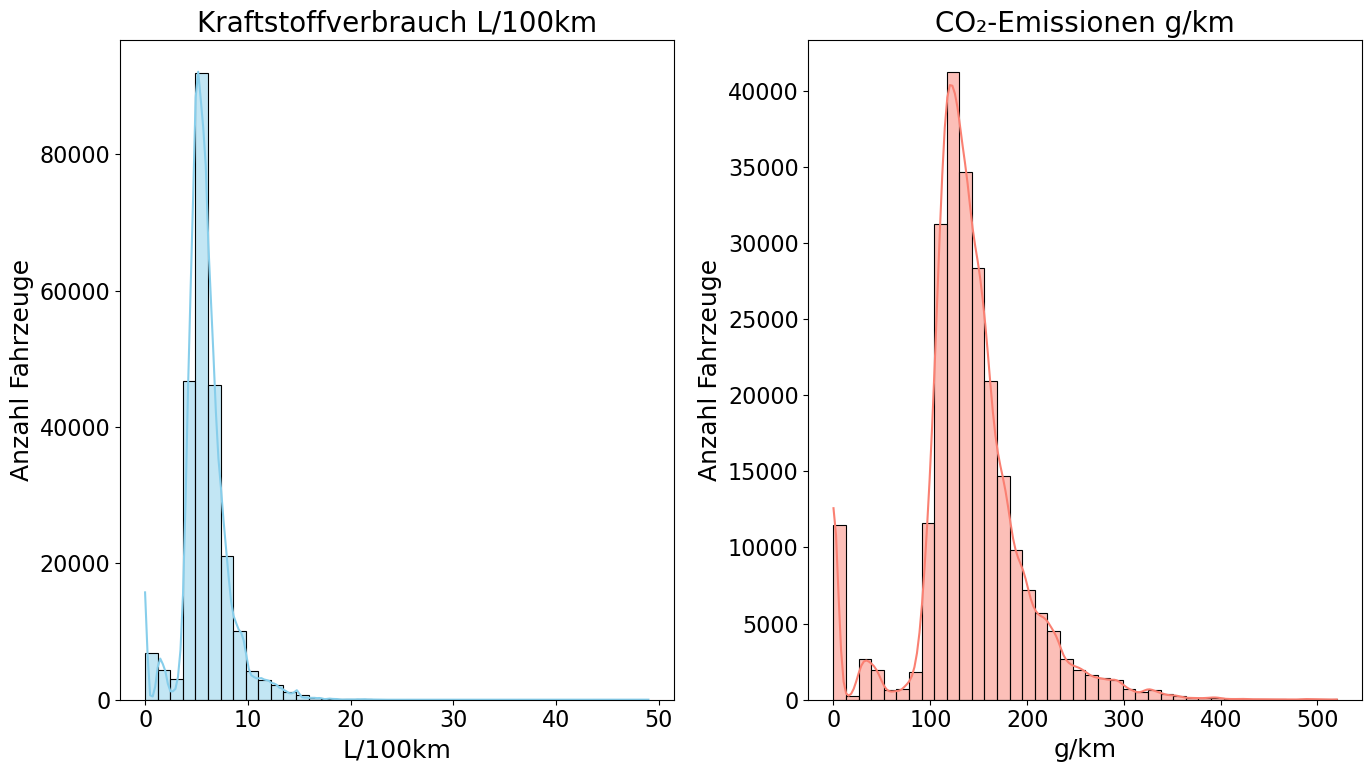

In [25]:
df_fuel_l100 = df["fuel_consumption_l_100km"][df["fuel_consumption_l_100km"] < 50]
percent_l100 = round((df["fuel_consumption_l_100km"] < 50).mean() * 100, 2)

df_co2_gkm = df["fuel_consumption_g_km"][df["fuel_consumption_g_km"] < 600]
percent_co2 = round((df["fuel_consumption_g_km"] < 600).mean() * 100, 2)

print(f"Prozent unter 50 L/100km: {percent_l100}%")
print(f"Prozent unter 600 g/km CO₂: {percent_co2}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.histplot(df_fuel_l100.dropna(), bins=40, ax=axes[0],kde=True, color="skyblue")
axes[0].set_title("Kraftstoffverbrauch L/100km")
axes[0].set_xlabel("L/100km")
axes[0].set_ylabel("Anzahl Fahrzeuge")

sns.histplot(df_co2_gkm.dropna(), bins=40, ax=axes[1],kde=True, color="salmon")
axes[1].set_title("CO₂-Emissionen g/km")
axes[1].set_xlabel("g/km")
axes[1].set_ylabel("Anzahl Fahrzeuge")

plt.tight_layout()
plt.show()


In [26]:
df["fuel_consumption_l_100km"] = df["fuel_consumption_l_100km"].mask(
    (df["fuel_consumption_l_100km"]>50),
    df["fuel_consumption_l_100km"].median()
)
df["fuel_consumption_g_km"] = df["fuel_consumption_g_km"].mask(
    (df["fuel_consumption_g_km"] > 600),
    df["fuel_consumption_g_km"].median()
) 

In [27]:
print(df[(df["is_electric"]== False) & (df["fuel_consumption_l_100km"]==0)].shape)
df[(df["is_electric"]== False) & (df["fuel_consumption_g_km"]==0)].shape

(32, 15)


(5419, 15)

- Sehr viele nicht elektrische Autos haben den Wert 0.
- Diese Werte werden durch den lokalen Median ersetzt

In [28]:
cols = ["fuel_consumption_l_100km", "fuel_consumption_g_km"]
for col in cols:
    median_per_group = df.groupby(["model","fuel_type","power_kw"])[col].transform('median')
    df[col] = df[col].mask(
        (df[col] == 0) & (~df["is_electric"]),
        median_per_group
    )

df["fuel_consumption_g_km"] = df["fuel_consumption_g_km"].mask(
    (df["fuel_consumption_g_km"]== 0)& ~df["is_electric"],
    df["fuel_consumption_g_km"].median())

df["fuel_consumption_l_100km"] = df["fuel_consumption_l_100km"].mask(
    (df["fuel_consumption_l_100km"]== 0)& ~df["is_electric"],
    df["fuel_consumption_l_100km"].median())
df.head()

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,is_electric
0,alfa-romeo,Alfa Romeo GTV,red,1995-10-01,1995-01-01,1300.0,148.0,201.0,Manual,Petrol,10.9,260.0,160500.0,2.0 V6 TB,False
1,alfa-romeo,Alfa Romeo Spider,black,1995-02-01,1995-01-01,5900.0,110.0,150.0,Unknown,Petrol,9.5,225.0,129000.0,ALFA ROME 916,False
2,alfa-romeo,Alfa Romeo Spider,black,1995-07-01,1995-01-01,4900.0,110.0,150.0,Manual,Petrol,9.5,225.0,189500.0,2.0 16V Twin Spark L,False
3,alfa-romeo,Alfa Romeo 164,red,1996-11-01,1996-01-01,17950.0,132.0,179.0,Manual,Petrol,7.2,320.0,96127.0,"3.0i Super V6, absoluter Topzustand !",False
4,alfa-romeo,Alfa Romeo Spider,red,1996-04-01,1996-01-01,7900.0,110.0,150.0,Manual,Petrol,9.5,225.0,47307.0,2.0 16V Twin Spark,False


- Leistung

In [29]:
df[df["power_ps"] > 900].head(5)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,is_electric
50484,ferrari,Ferrari SF90 Spider,blue,2021-07-01,2021-01-01,699980.0,735.0,999.0,Automatic,Hybrid,12.30,280.0,2332.0,*Ferrari-Dresden*,False
50492,ferrari,Ferrari SF90 Stradale,grey,2021-12-01,2021-01-01,549900.0,735.0,999.0,Automatic,Hybrid,7.40,330.0,1000.0,Assetto Fiorano,False
50511,ferrari,Ferrari SF90 Stradale,red,2021-05-01,2021-01-01,520000.0,735.0,999.0,Automatic,Hybrid,9.85,280.0,1300.0,Assetto Fiorona Paket,False
50518,ferrari,Ferrari SF90 Stradale,red,2021-07-01,2021-01-01,492888.0,735.0,999.0,Automatic,Hybrid,9.85,280.0,5000.0,Rosso / Cuoio aus 1. Hand,False
50530,ferrari,Ferrari SF90 Stradale,black,2021-05-01,2021-01-01,529000.0,735.0,999.0,Automatic,Hybrid,9.85,280.0,6149.0,| Assetto Fiorano Paket,False


- es gibt Autos die auch mehr haben

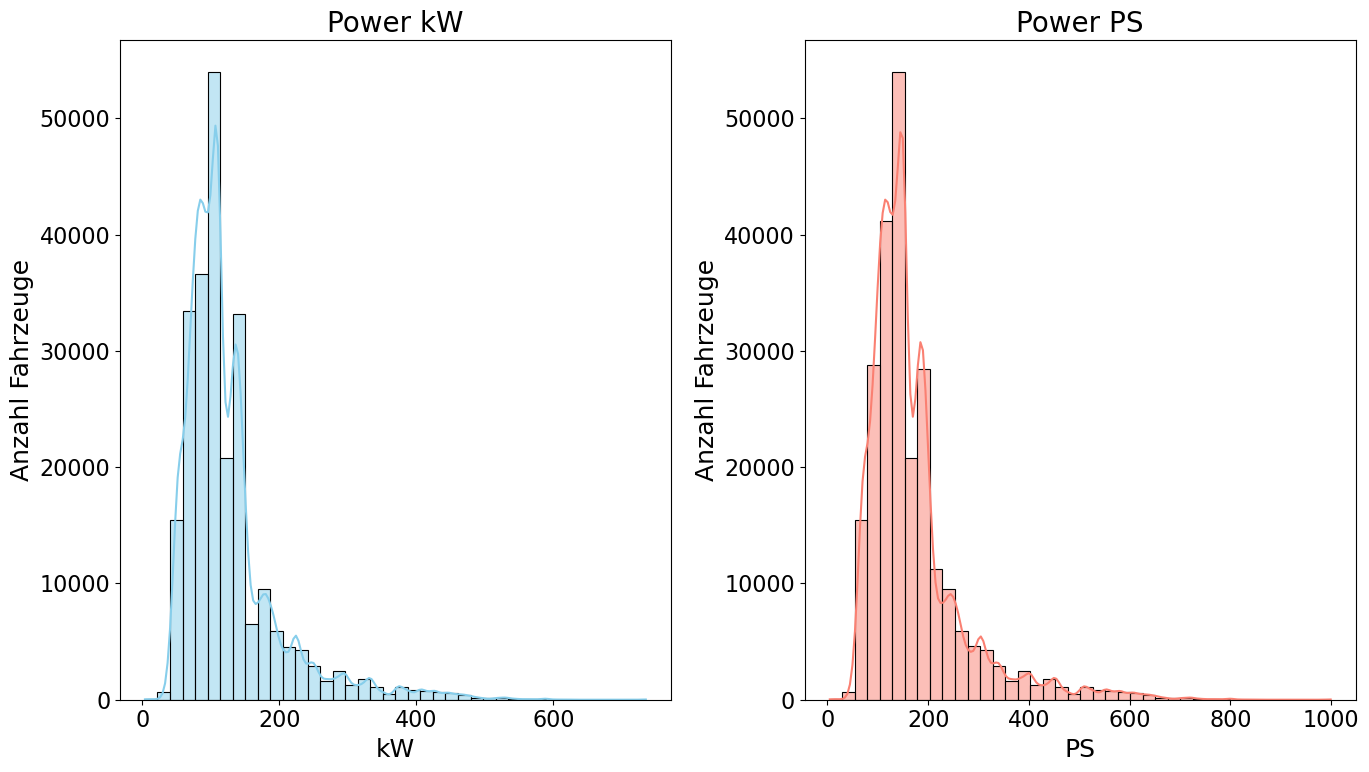

In [30]:
df_kw = df["power_kw"]
df_ps = df["power_ps"]

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.histplot(df_kw.dropna(), bins=40, ax=axes[0], kde=True,color="skyblue")
axes[0].set_title("Power kW")
axes[0].set_xlabel("kW")
axes[0].set_ylabel("Anzahl Fahrzeuge")


sns.histplot(df_ps.dropna(), bins=40, ax=axes[1], kde=True,color="salmon")
axes[1].set_title("Power PS")
axes[1].set_xlabel("PS")
axes[1].set_ylabel("Anzahl Fahrzeuge")

plt.tight_layout()
plt.show()



In [31]:
df.describe().round(2)

,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
count,241585.00,241585.00,241585.00,241585.00,241585.00,241585.00
mean,25978.71,126.44,171.99,5.92,143.46,86498.13
std,36204.98,71.95,97.80,2.21,52.45,78393.35
min,120.00,4.00,5.00,0.00,0.00,0.00
25%,11900.00,84.00,114.00,4.80,117.00,26500.00
50%,19688.00,110.00,150.00,5.70,137.00,69000.00
75%,29899.00,140.00,190.00,6.80,164.00,128000.00
max,5890500.00,735.00,999.00,49.00,520.00,3800000.00


- Hohe Autopreise sind normal

In [32]:
Q1 = df["price_in_euro"].quantile(0.25)
Q3 = df["price_in_euro"].quantile(0.75)
IQR = Q3 - Q1

df["outliers"] = ((df["price_in_euro"] < (Q1 - 1.5 * IQR)) | (df["price_in_euro"] > (Q3 + 1.5 * IQR)))

df[df["outliers"]].head()


,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,is_electric,outliers
313,alfa-romeo,Alfa Romeo 8C,white,2009-10-01,2009-01-01,249450.0,331.0,450.0,Automatic,Petrol,16.8,379.0,13128.0,Spider * deutsche Auslieferung *,False,True
347,alfa-romeo,Alfa Romeo 8C,white,2010-03-01,2010-01-01,249000.0,331.0,450.0,Semi-automatic,Petrol,16.8,379.0,29400.0,"Spider, limitierte Serie",False,True
399,alfa-romeo,Alfa Romeo 8C,white,2011-04-01,2011-01-01,289890.0,331.0,450.0,Automatic,Petrol,16.8,379.0,3084.0,Spider 1 of 500 I Carbon I 1. Hand I 3084 km,False,True
457,alfa-romeo,Alfa Romeo MiTo,red,2013-12-01,2013-01-01,259900.0,51.0,69.0,Manual,Petrol,5.8,134.0,119377.0,1.4 8V Impression aus 1.Hand,False,True
486,alfa-romeo,Alfa Romeo 4C,white,2014-07-01,2014-01-01,72990.0,177.0,241.0,Automatic,Petrol,6.8,157.0,16800.0,1.8 TBi 16V 240PS AT-6 Klima Leder Einparkhilfe,False,True


In [33]:
df.drop(columns="outliers", inplace=True)

In [34]:
Q1_mileage = df["mileage_in_km"].quantile(0.25)
Q3_mileage = df["mileage_in_km"].quantile(0.75)
IQR_mileage = Q3_mileage - Q1_mileage


mileage_outliers = df[
    (df["mileage_in_km"] < (Q1_mileage - 1.5 * IQR_mileage)) | 
    (df["mileage_in_km"] > (Q3_mileage + 1.5 * IQR_mileage))
]

print("Anzahl der Mileage-Ausreißer:", len(mileage_outliers))



Anzahl der Mileage-Ausreißer: 4888


In [35]:
df.describe().round(2)

,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
count,241585.00,241585.00,241585.00,241585.00,241585.00,241585.00
mean,25978.71,126.44,171.99,5.92,143.46,86498.13
std,36204.98,71.95,97.80,2.21,52.45,78393.35
min,120.00,4.00,5.00,0.00,0.00,0.00
25%,11900.00,84.00,114.00,4.80,117.00,26500.00
50%,19688.00,110.00,150.00,5.70,137.00,69000.00
75%,29899.00,140.00,190.00,6.80,164.00,128000.00
max,5890500.00,735.00,999.00,49.00,520.00,3800000.00


## Numerical Data

- nochmal in der graphishen Übersicht 
- 1-99 % für bessere Ansicht

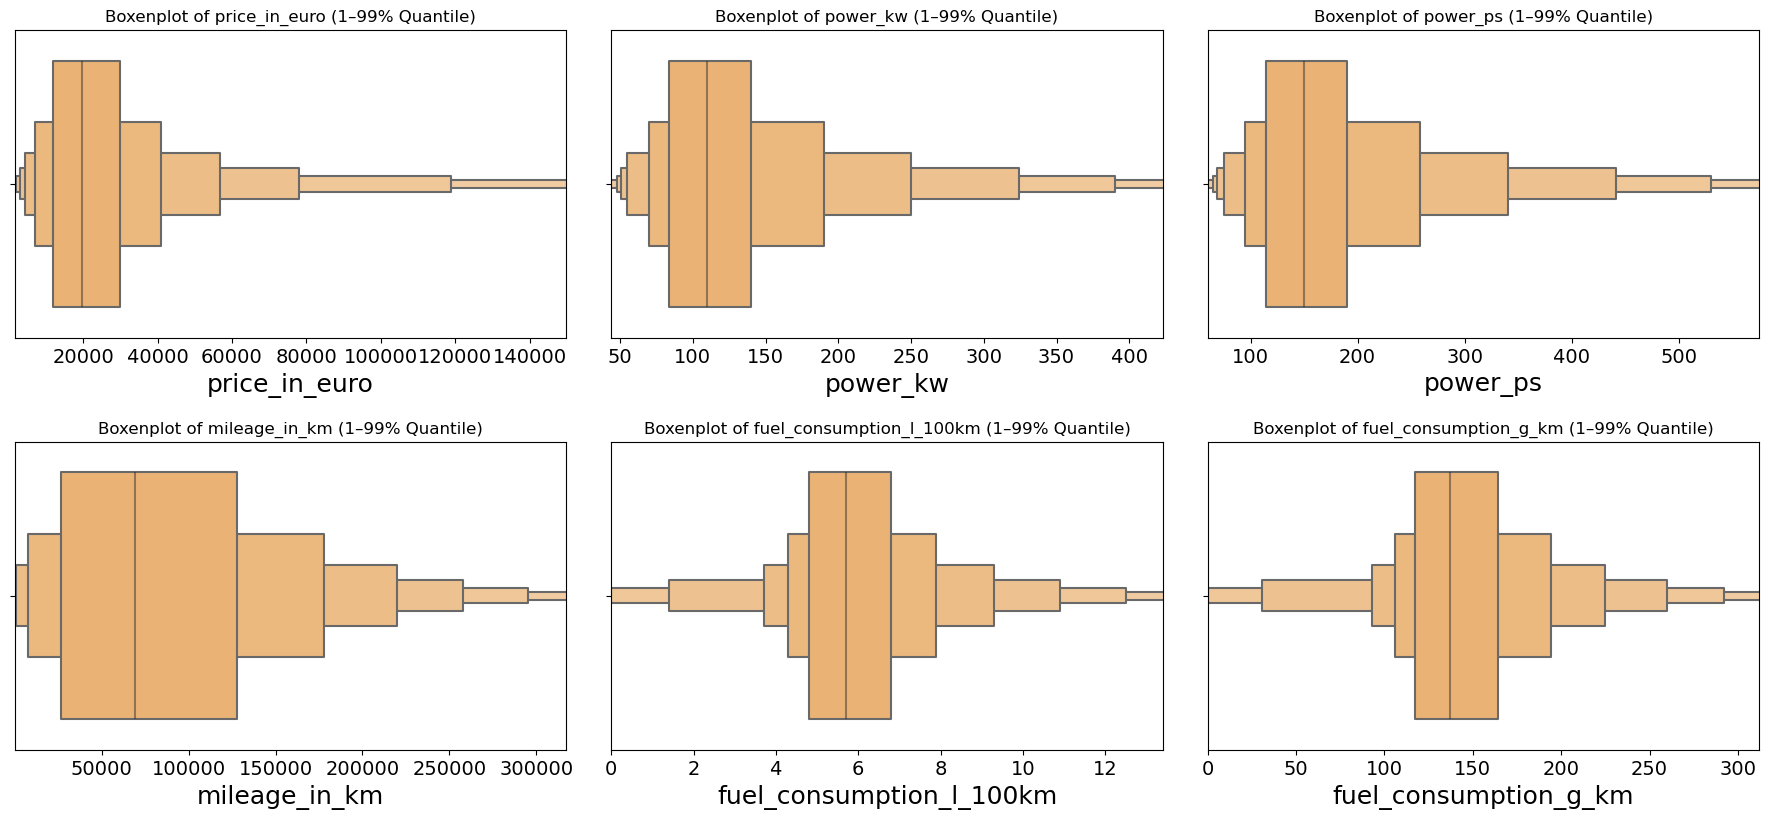

In [80]:
numerical_columns = [
    'price_in_euro', 'power_kw', 'power_ps', 'mileage_in_km',
    'fuel_consumption_l_100km', 'fuel_consumption_g_km'
]

plt.figure(figsize=(18, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    
    lower, upper = df[col].quantile([0.01, 0.99])
    sns.boxenplot(x=df[col],palette="Set3_r")
    plt.xlim(lower, upper)
    
    plt.title(f'Boxenplot of {col} (1–99% Quantile)',fontsize=12)

plt.tight_layout()
plt.show()




## Categorical Data

In [37]:
df.describe(include="object")

,brand,model,color,transmission_type,fuel_type,offer_description
count,241585,241585,241585,241585,241585,241585
unique,46,1230,14,4,11,198357
top,volkswagen,Volkswagen Golf,black,Automatic,Petrol,Titanium
freq,32540,7489,56987,127059,138372,173


#### Brand 

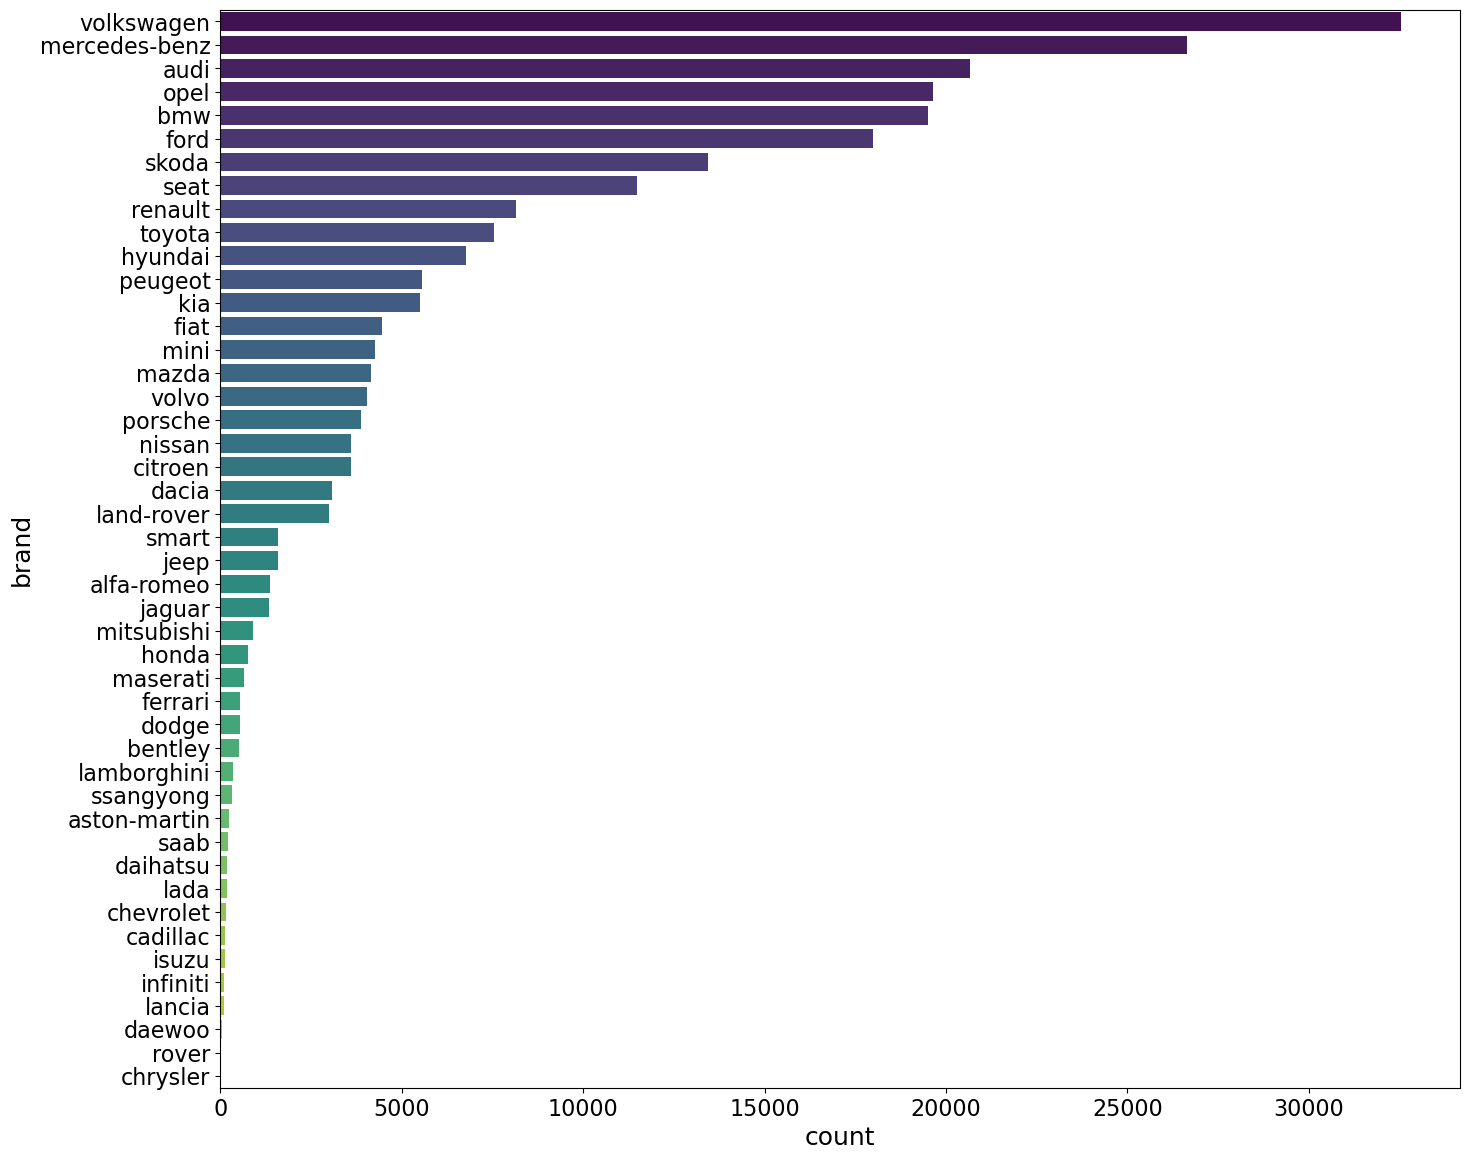

In [38]:
plt.figure(figsize=(16,14))
sns.countplot(y='brand', data=df, order=df['brand'].value_counts().index, palette='viridis')
plt.show()


- viele Marken haben nur wenige Fahrzeuge

#### Model

In [39]:
df['model'].nunique()


1230

Text(0, 0.5, 'Top 20 Models')

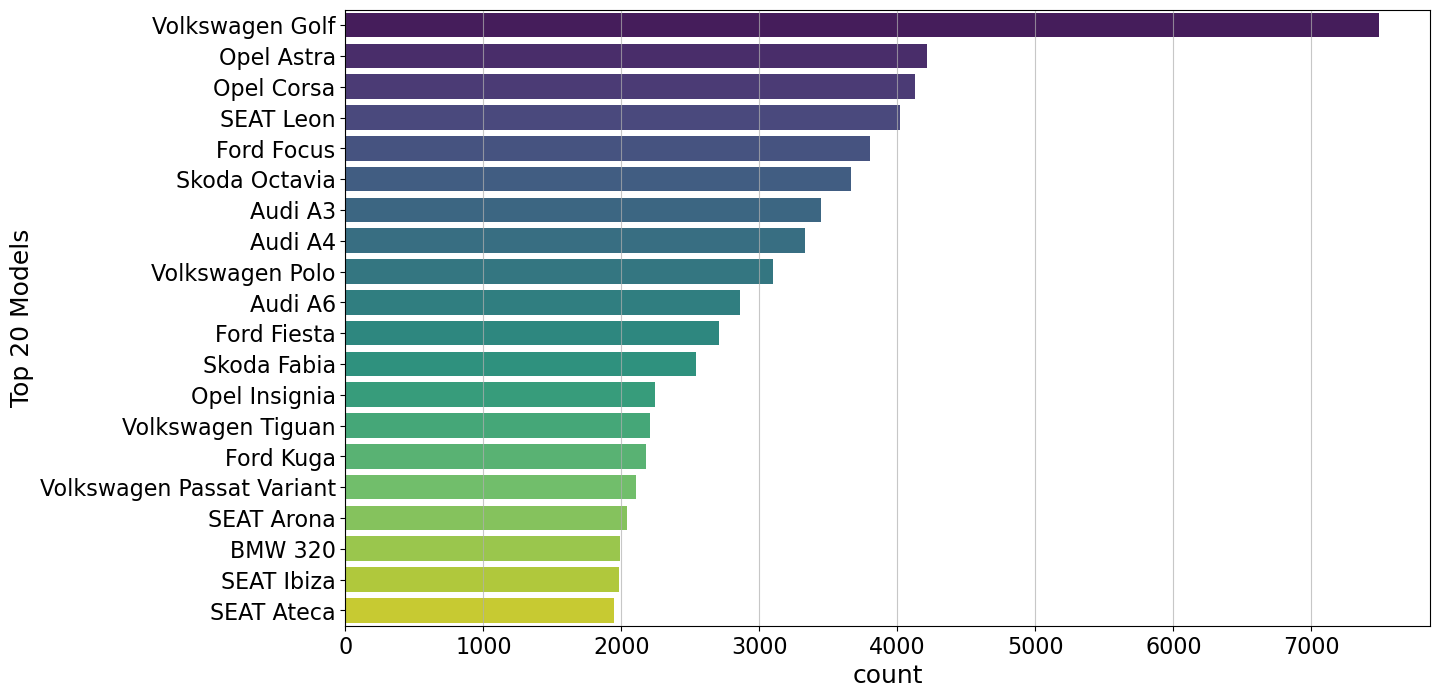

In [40]:
plt.figure(figsize=(14, 8))

top20 = df['model'].value_counts().nlargest(20).index

sns.countplot(
    y='model',
    data=df,
    order=top20,
    palette='viridis'
)
plt.grid(alpha=0.7, axis='x')
plt.ylabel('Top 20 Models')


#### Color

In [41]:
df["color"].value_counts()

black     56987
grey      45339
white     38856
silver    33221
blue      30652
red       20353
brown      4258
green      3339
orange     3150
beige      2237
yellow     1692
gold        560
bronze      555
violet      386
Name: color, dtype: int64

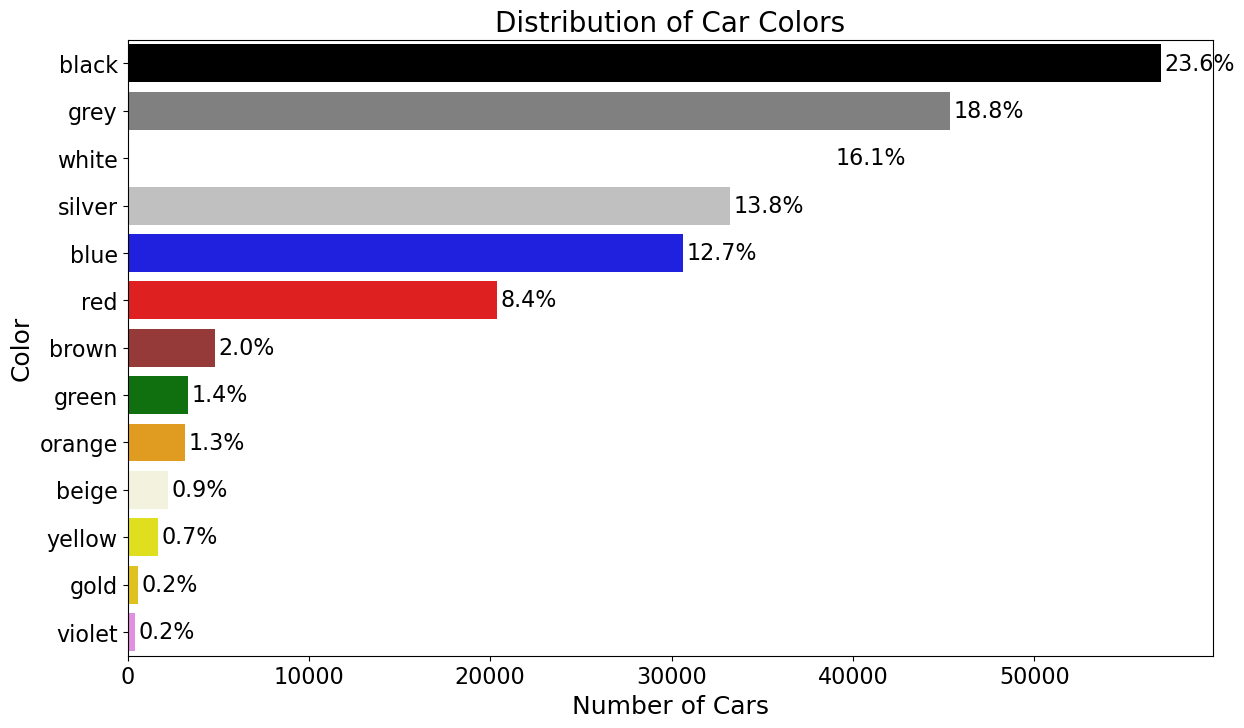

In [42]:
df_plot = df.copy()
df_plot['color_plot'] = df_plot['color'].replace({'bronze': 'brown'})

plt.figure(figsize=(14, 8))
ax = sns.countplot(
    data=df_plot,
    y='color_plot',
    order=df_plot['color_plot'].value_counts().index,
    palette=df_plot['color_plot'].value_counts().index
)

total = len(df_plot)
for p in ax.patches:
    count = int(p.get_width())
    percent = count / total * 100
    ax.text(
        count + 200,
        p.get_y() + p.get_height() / 2,
        f'{percent:.1f}%',
        va='center'
    )

plt.ylabel('Color')
plt.xlabel('Number of Cars')
plt.title('Distribution of Car Colors')

plt.show()


#### Transmission


In [43]:
total_counts = df.groupby("brand").size()
unknown_counts = df[df["transmission_type"]=="Unknown"].groupby("brand").size()
unknown_ratio = (unknown_counts / total_counts * 100).sort_values(ascending=False).fillna(0)
print(unknown_ratio)


brand
chrysler         4.000000
ferrari          1.996370
chevrolet        1.234568
honda            1.181102
lamborghini      1.152738
alfa-romeo       1.028655
saab             0.966184
infiniti         0.961538
volvo            0.886700
ford             0.844867
cadillac         0.787402
aston-martin     0.778210
porsche          0.721649
land-rover       0.598404
peugeot          0.594273
hyundai          0.590842
opel             0.585301
nissan           0.554170
lada             0.549451
daihatsu         0.512821
seat             0.496516
bmw              0.476752
mitsubishi       0.447427
smart            0.439147
mercedes-benz    0.394277
volkswagen       0.387216
kia              0.363174
fiat             0.358584
renault          0.319410
ssangyong        0.302115
audi             0.300257
citroen          0.250139
skoda            0.238078
jaguar           0.221239
dacia            0.161917
mazda            0.144509
toyota           0.132732
jeep             0.125628
mini  

In [44]:
df = df[df['transmission_type'] != "Unknown"]
df.reset_index(inplace=True, drop=True)
df.shape

(240505, 15)

<Figure size 1400x800 with 0 Axes>

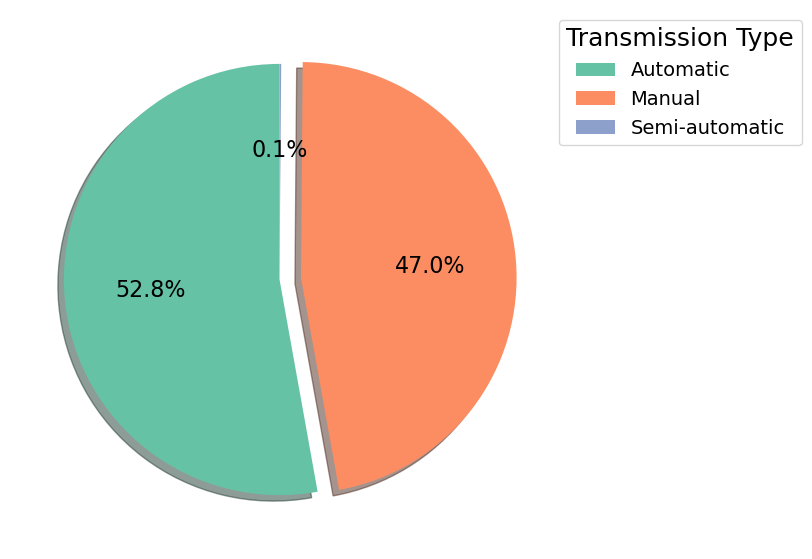

In [45]:
plt.figure(figsize=(14,8))

explode = (0, 0.1, 0)

transmission_counts = df['transmission_type'].value_counts()
fig, ax = plt.subplots()
ax.pie(transmission_counts, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90,colors=sns.color_palette("Set2"))
ax.legend(transmission_counts.index, title="Transmission Type", bbox_to_anchor=(1,1))

plt.show()



- die Verteilung zwischen Automatik und Manuell relativ ausgeglichen

#### Fuel Type (Kraftstoffart)

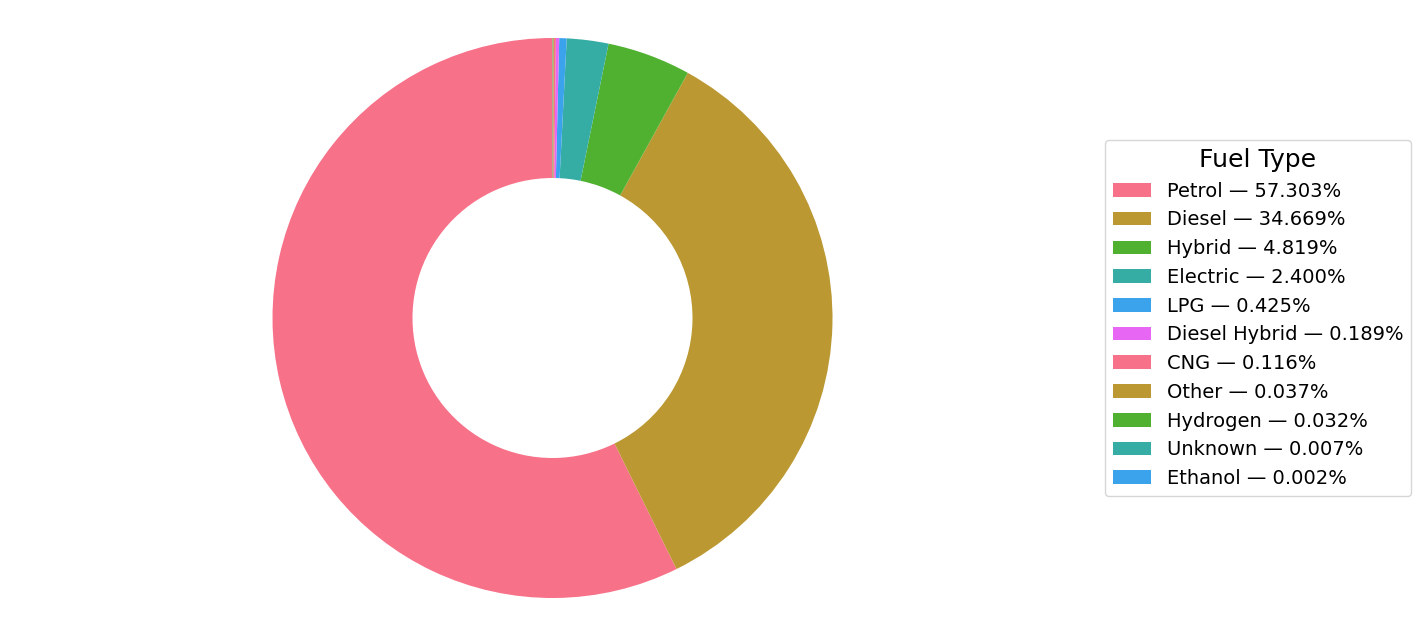

In [46]:
counts = df['fuel_type'].value_counts()
colors = sns.color_palette("husl")

fig, ax = plt.subplots(figsize=(14,8))

wedges, texts = ax.pie(
    counts,
    labels=None,          
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.5)
)

# Prozent + Label in Legende
total_f = counts.sum()
legend_labels = [f"{c} — {n/total_f:.3%}" for c, n in zip(counts.index, counts)]
ax.legend(
    wedges, 
    legend_labels,
    title="Fuel Type",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.axis('equal')
plt.show()


- Der Datensatz wird klar von Benzin- und Dieselfahrzeugen dominiert

In [47]:
#! pip install association-metrics

## Multivariate Analysis

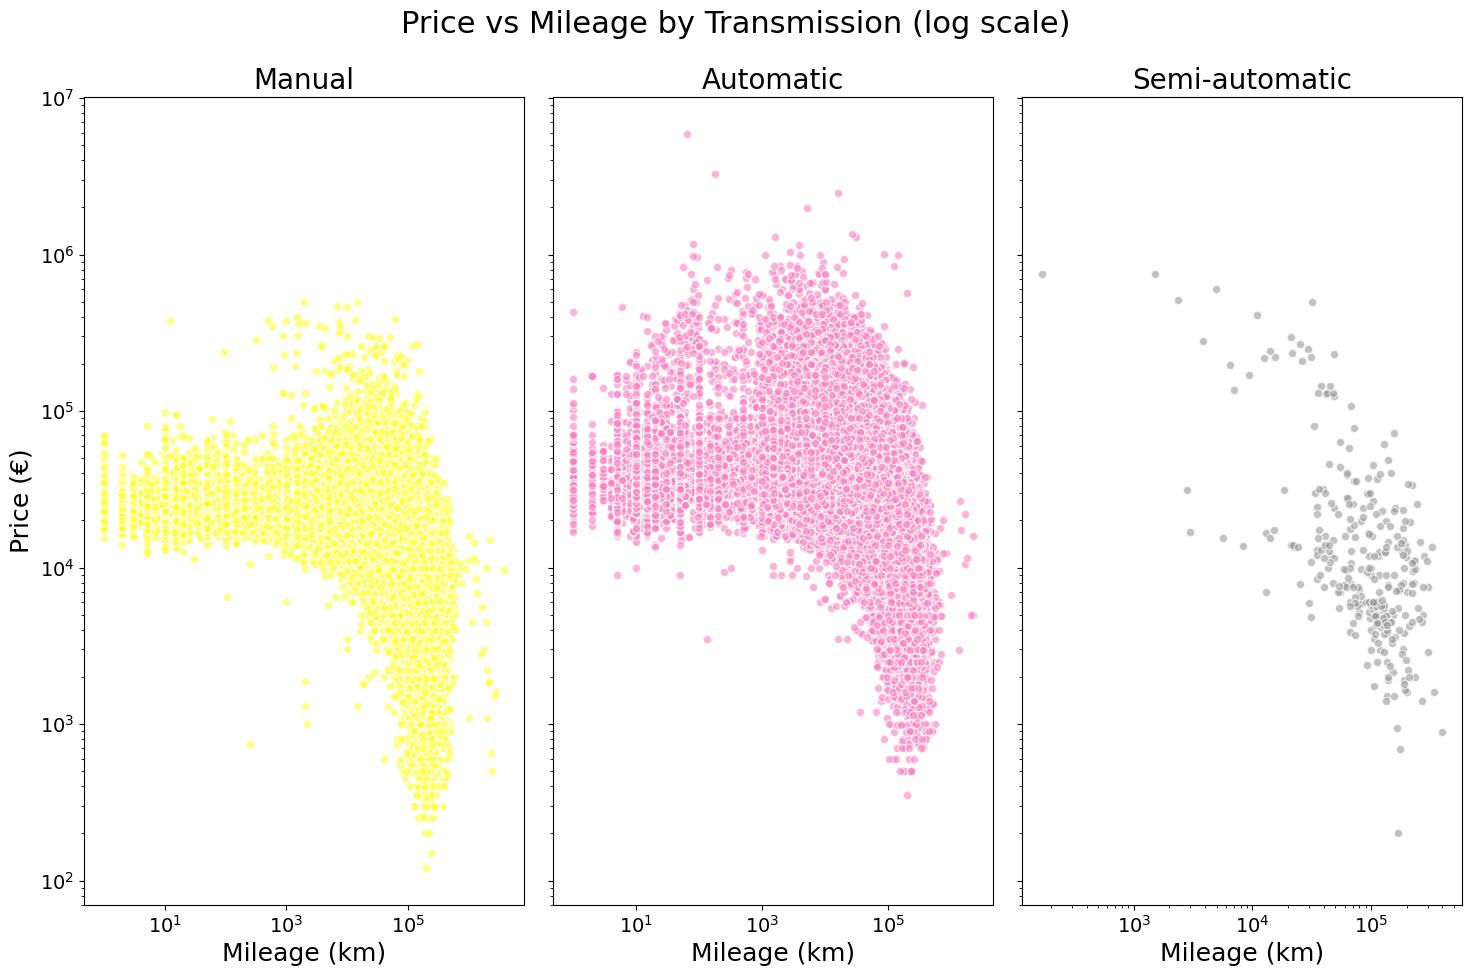

In [81]:
fig, axes = plt.subplots(
    1,
    df['transmission_type'].nunique(),
    figsize=(15,10),
    sharey=True
)

for ax, t in zip(axes, df['transmission_type'].unique()):
    subset = df[df['transmission_type'] == t]
    
    ax.scatter(
        subset['mileage_in_km'],
        subset['price_in_euro'],
        alpha=0.6,
        color=sns.color_palette("Set1")[np.random.randint(0,9)],
        edgecolors='w',
    )
    ax.set_title(t)
    ax.set_xlabel('Mileage (km)',fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')

axes[0].set_ylabel('Price (€)')
plt.suptitle('Price vs Mileage by Transmission (log scale)',fontsize=22)
plt.tight_layout()
plt.show()



- Mit steigender Kilometerzahl sinkt der Preis deutlich
- Insgesamt niedrigere Preise bei manuellen Fahrzeugen  als bei Automatikfahrzeugen.

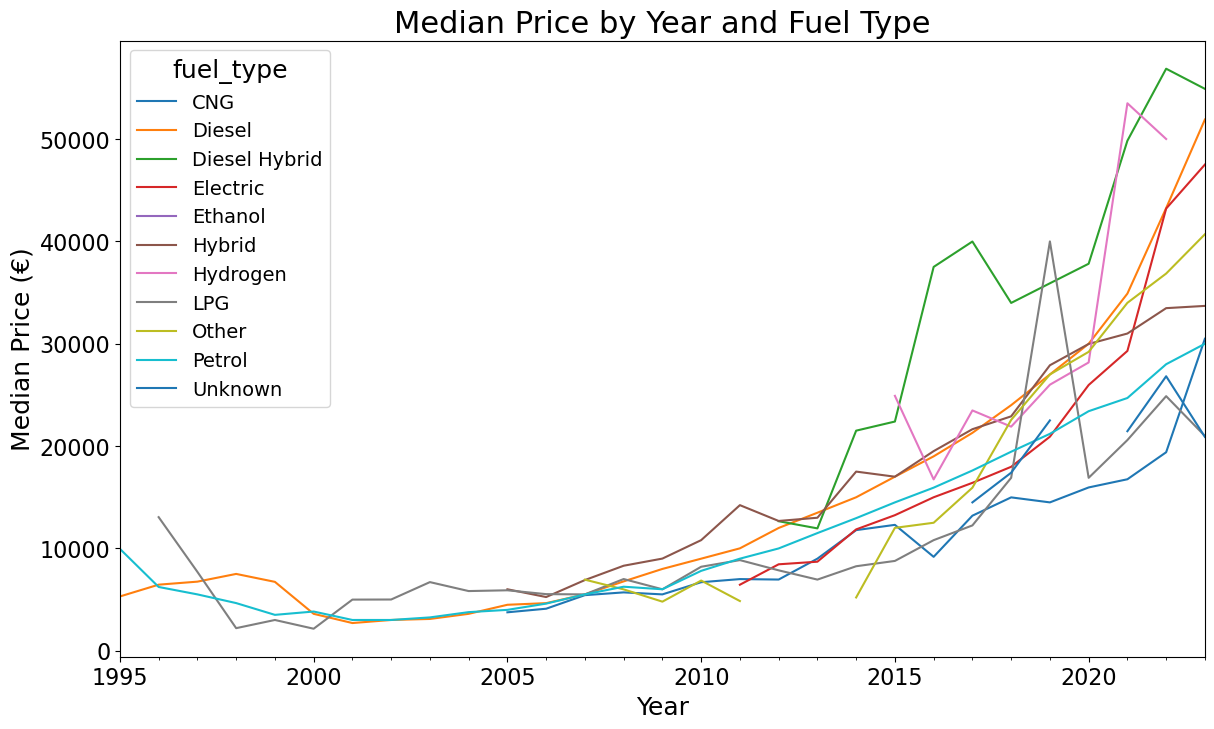

In [49]:
grouped = df.groupby(['year', 'fuel_type'])['price_in_euro'].median().unstack()

grouped.plot(figsize=(14,8))
plt.ylabel('Median Price (€)', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.title('Median Price by Year and Fuel Type', fontsize=22)
plt.show()


- Neuere Baujahre sind deutlich teurer als ältere
- Benzin- und Dieselfahrzeuge zeigen einen stetigen Preisanstieg über die Jahre.
- Hybrid- und Elektrofahrzeuge weisen ab etwa 2015 einen starken Preisanstieg auf

In [50]:
df[(df["year"].isin(["2014", "2015"])) & (df["fuel_type"] == "Hybrid")].groupby('brand')['price_in_euro'].median().sort_values(ascending=False)
# neue panamaera cayenne

brand
bmw              59900.0
porsche          49900.0
mercedes-benz    37445.0
infiniti         22275.0
audi             17745.0
volkswagen       17645.0
opel             16000.0
toyota           14200.0
ford             12950.0
Name: price_in_euro, dtype: float64

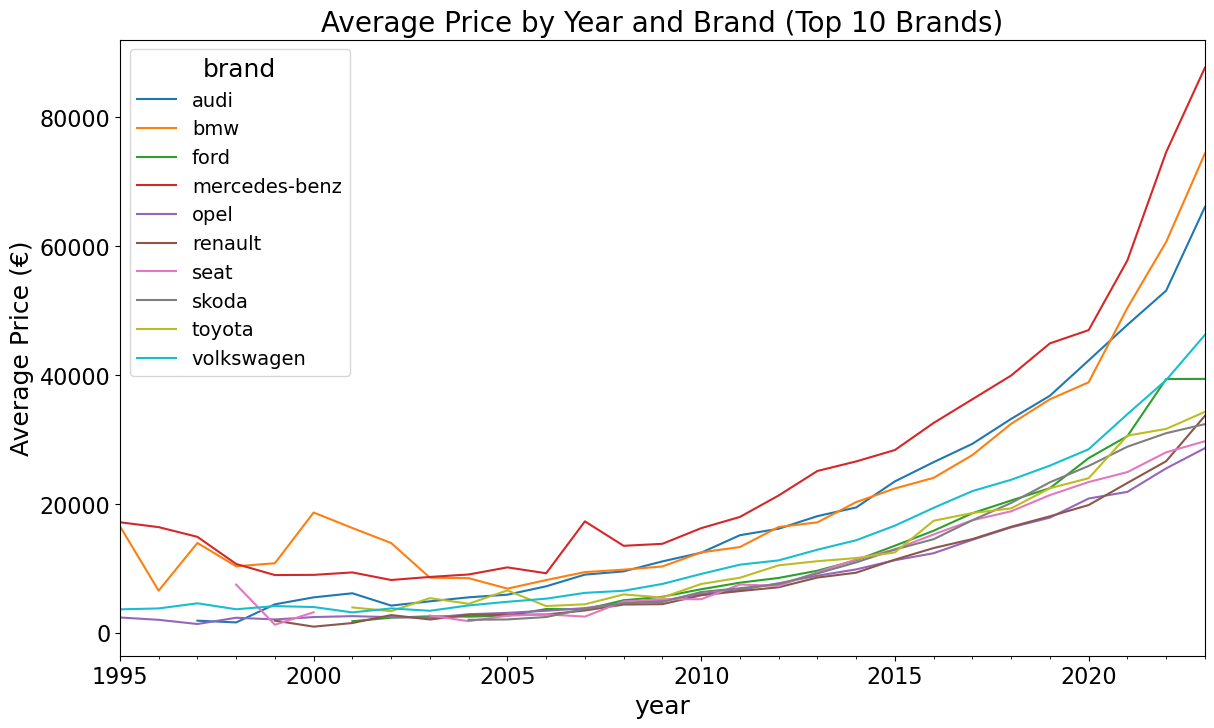

In [51]:
top_brands = df['brand'].value_counts().nlargest(10).index
df_top = df[df['brand'].isin(top_brands)]
grouped = df_top.groupby(['year', 'brand'])['price_in_euro'].mean().unstack()
grouped.plot(figsize=(14,8))
plt.ylabel('Average Price (€)')
plt.title('Average Price by Year and Brand (Top 10 Brands)')
plt.show()

- Premiumhersteller erzielen deutlich höhere Durchschnittspreise als Volumenmarken

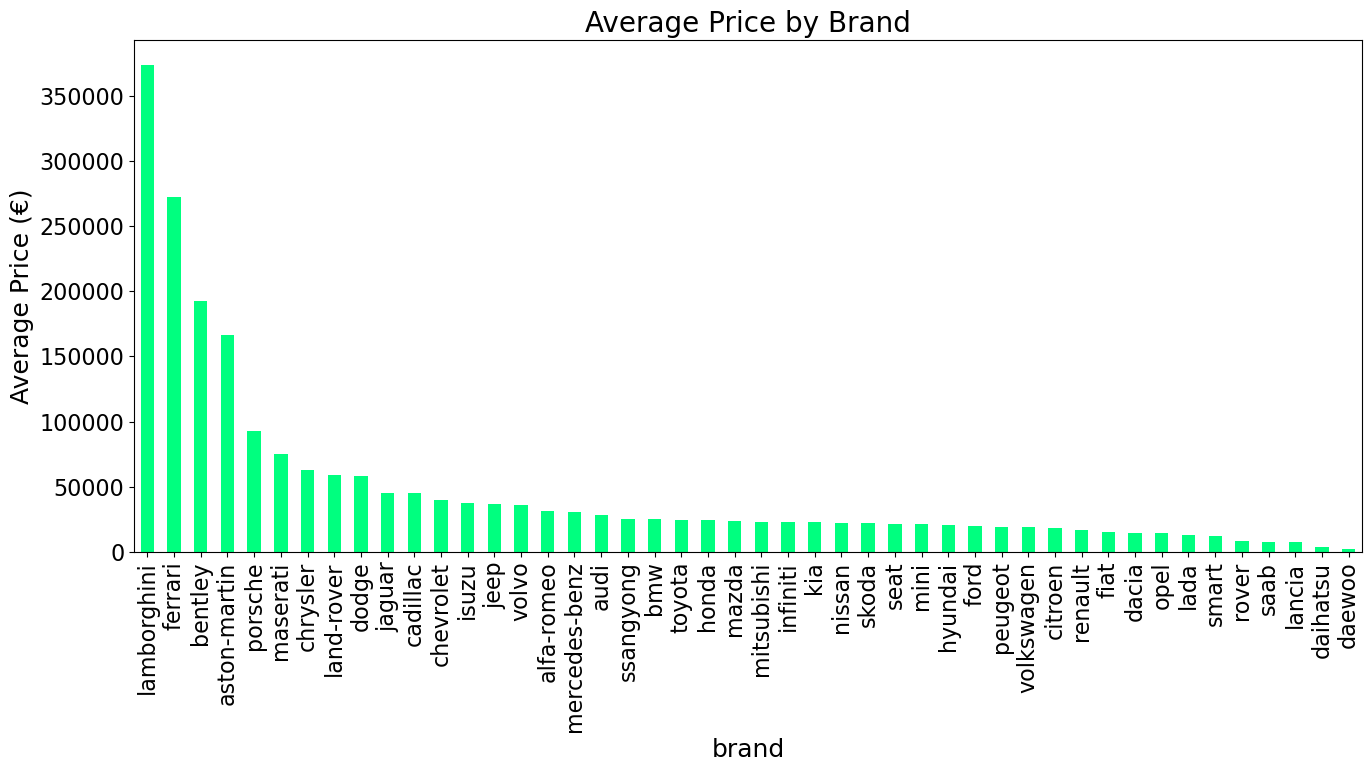

In [52]:
avg_price = df.groupby('brand')['price_in_euro'].mean().sort_values(ascending=False)

plt.figure(figsize=(14,8))
avg_price.plot(kind='bar', color='springgreen') 
plt.ylabel('Average Price (€)')
plt.title('Average Price by Brand')

plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()



In [53]:
brand_stats = df.groupby('brand').agg(
    avg_price=('price_in_euro', 'mean'),
    avg_power=('power_ps', 'mean')
).sort_values('avg_price', ascending=False)


top_brands = brand_stats.reset_index()
fig = px.scatter(
    top_brands,
    x='avg_power',
    y='avg_price',
    color='brand',                
    size='avg_price',          
    hover_name='brand',           
    text='brand',                
    size_max=50,
    labels={
        'avg_power': 'Average Power(PS)',
        'avg_price': 'Average Price (€)',
    },
    title='Average Price vs Power by Brand')

fig.update_traces(textposition='top center')

fig.show()


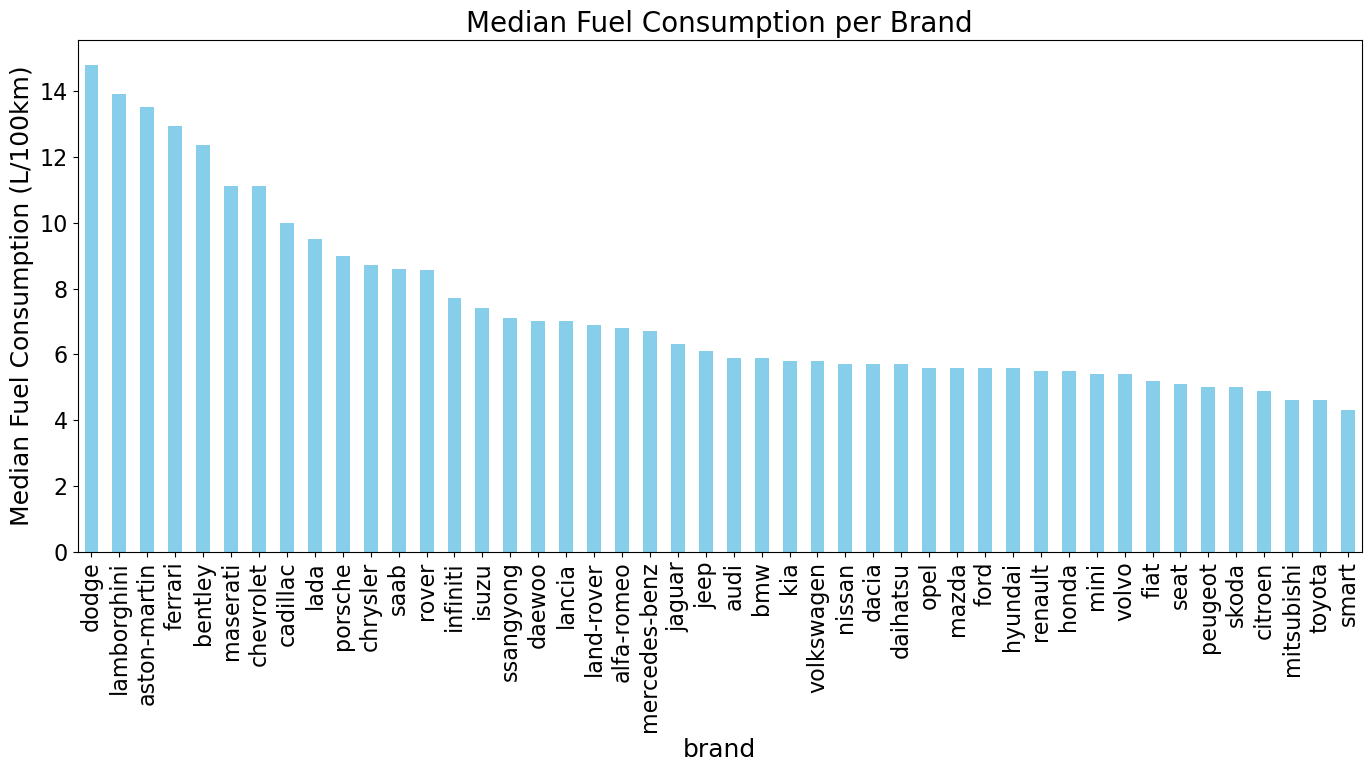

In [54]:
med_fuel = df[df["is_electric"]==False].groupby('brand')['fuel_consumption_l_100km'].median().sort_values(ascending=False)

plt.figure(figsize=(14,8))
med_fuel.plot(kind='bar', color='skyblue')
plt.ylabel('Median Fuel Consumption (L/100km)')
plt.title('Median Fuel Consumption per Brand')

plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

- Sport- und Luxusmarken haben den höchsten Verbrauch

<Figure size 2000x1600 with 0 Axes>

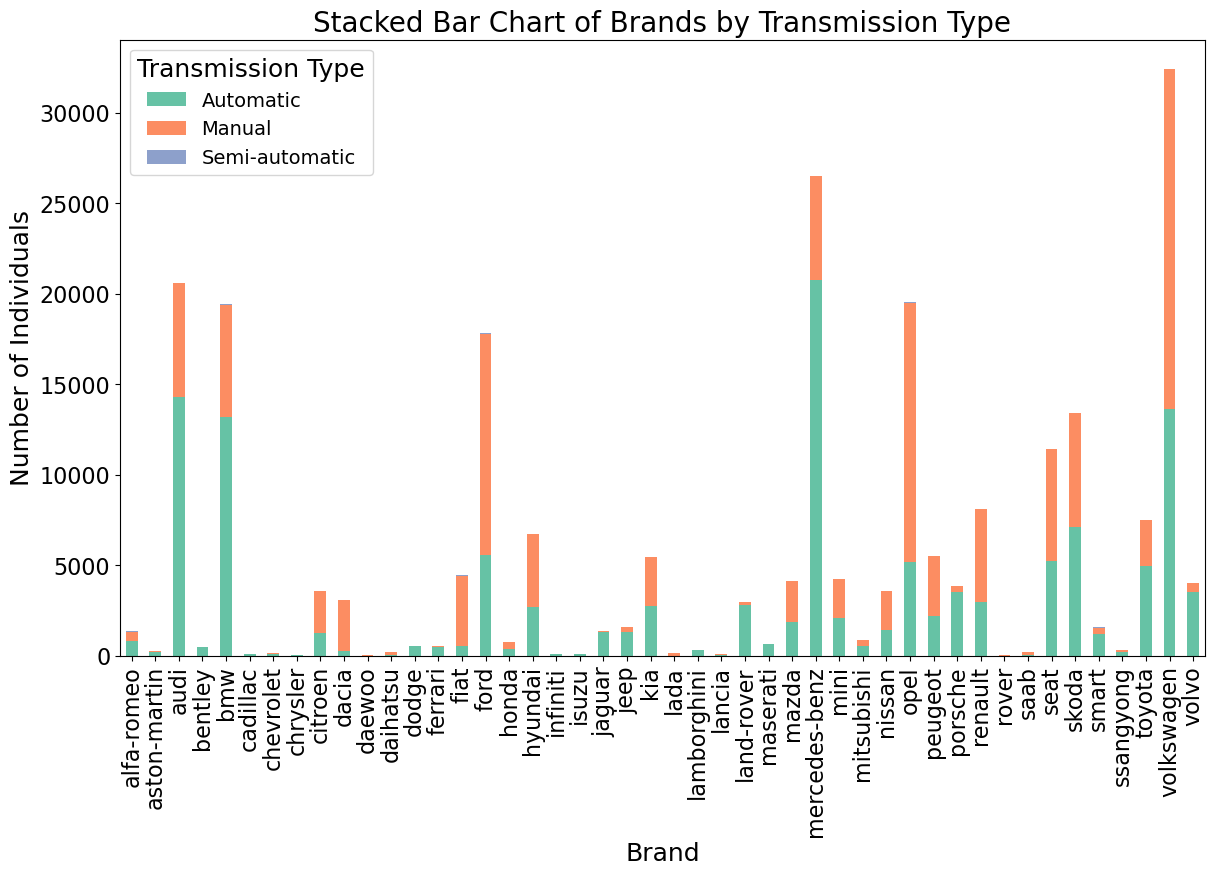

In [55]:
grouped_by_fuel = df.groupby(['brand', 'transmission_type']).size()
plt.figure(figsize=(20, 16))
grouped_by_fuel.unstack().plot(kind='bar', stacked=True, figsize=(14, 8), color=sns.color_palette("Set2"))
plt.title('Stacked Bar Chart of Brands by Transmission Type')
plt.xlabel('Brand')
plt.ylabel('Number of Individuals')
#plt.xticks(rotation=45)
plt.legend(title='Transmission Type')
plt.show()

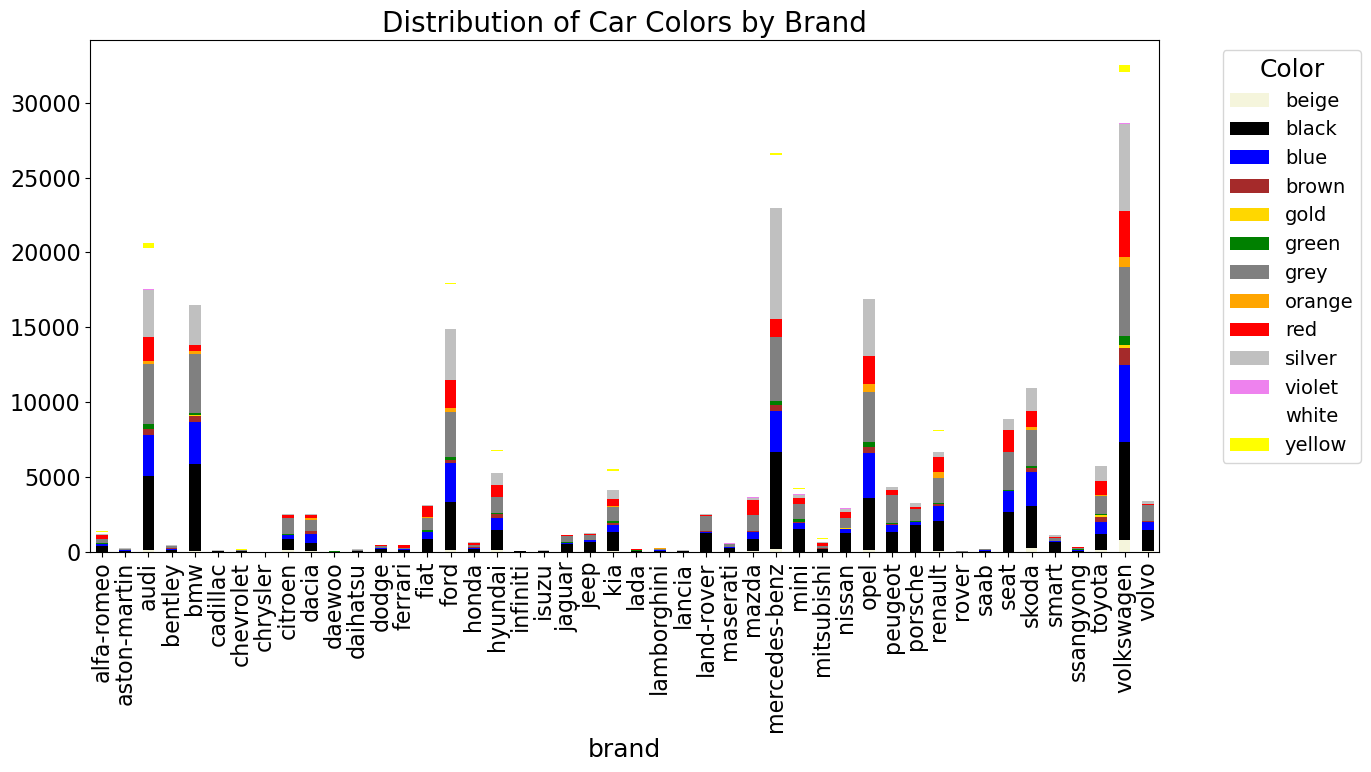

In [56]:
brand_color_counts = df_plot.groupby(['brand', 'color_plot']).size().unstack(fill_value=0)
colors = [c for c in brand_color_counts.columns]

brand_color_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(14,8),
    color=colors,
)
plt.title('Distribution of Car Colors by Brand')
plt.legend(title='Color', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


### Anova

- Um Anova durzuführen, muss der Preis Normalverteilt sein ,deshalb logarithmieren

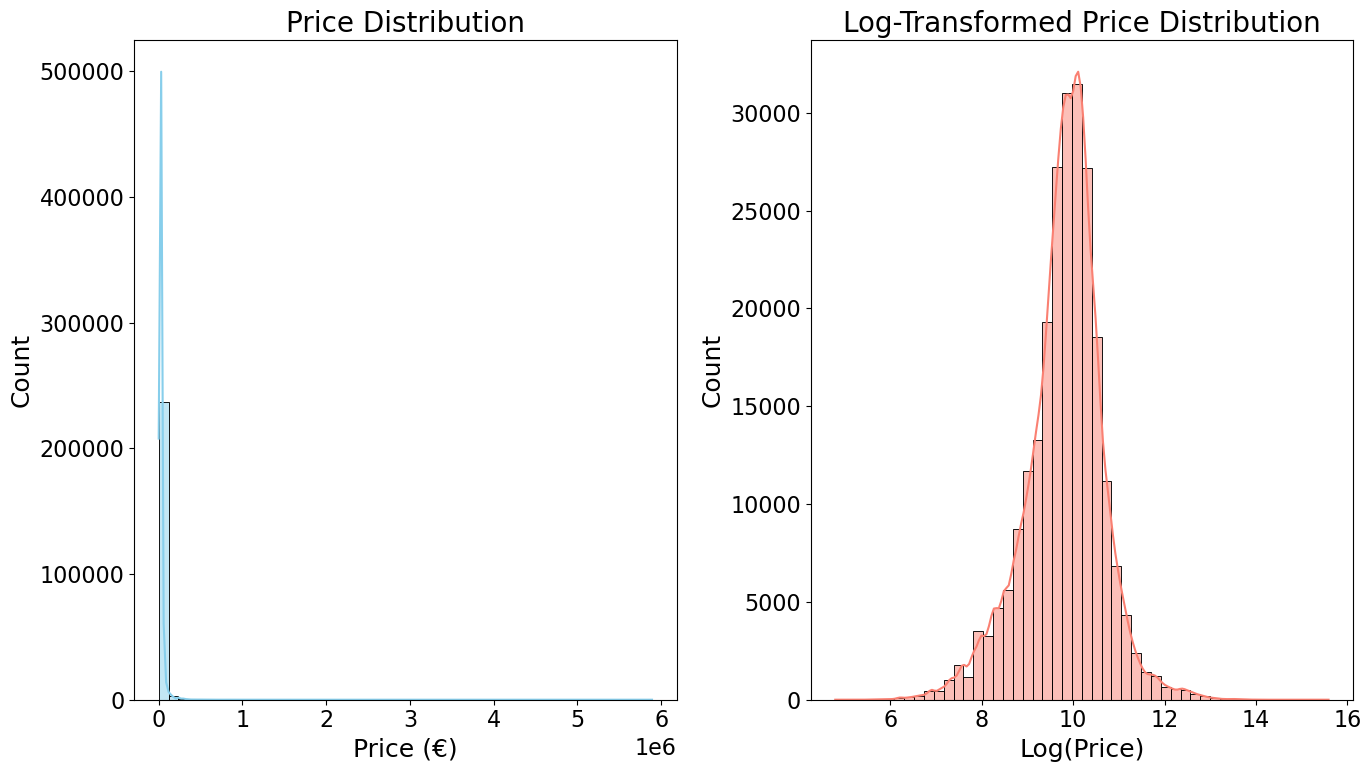

In [57]:
df['log_price'] = np.log1p(df['price_in_euro'])  # log1p = log(1+x) to avoid issues with zero values

# Plot
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
sns.histplot(df['price_in_euro'], bins=50, kde=True, color='skyblue')
plt.title("Price Distribution")
plt.xlabel("Price (€)")

plt.subplot(1, 2, 2)
sns.histplot(df['log_price'], bins=50, kde=True, color='salmon')
plt.title("Log-Transformed Price Distribution")
plt.xlabel("Log(Price)")

plt.tight_layout()
plt.show()


- Alle getesteten Features haben einen signifikanten Einfluss auf den Preis, $H_0$  ablehnen

In [58]:
from scipy.stats import f_oneway

cat_features = df.select_dtypes(include='object').columns
cat_features = cat_features.drop('offer_description')
for cat in cat_features:
    groups = [df[df[cat]==val]['log_price'] for val in df[cat].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"{cat}: F={f_stat:.2f}, p={p_value:.3g}")


brand: F=1481.28, p=0
model: F=249.01, p=0
color: F=615.47, p=0
transmission_type: F=38022.82, p=0
fuel_type: F=1034.17, p=0


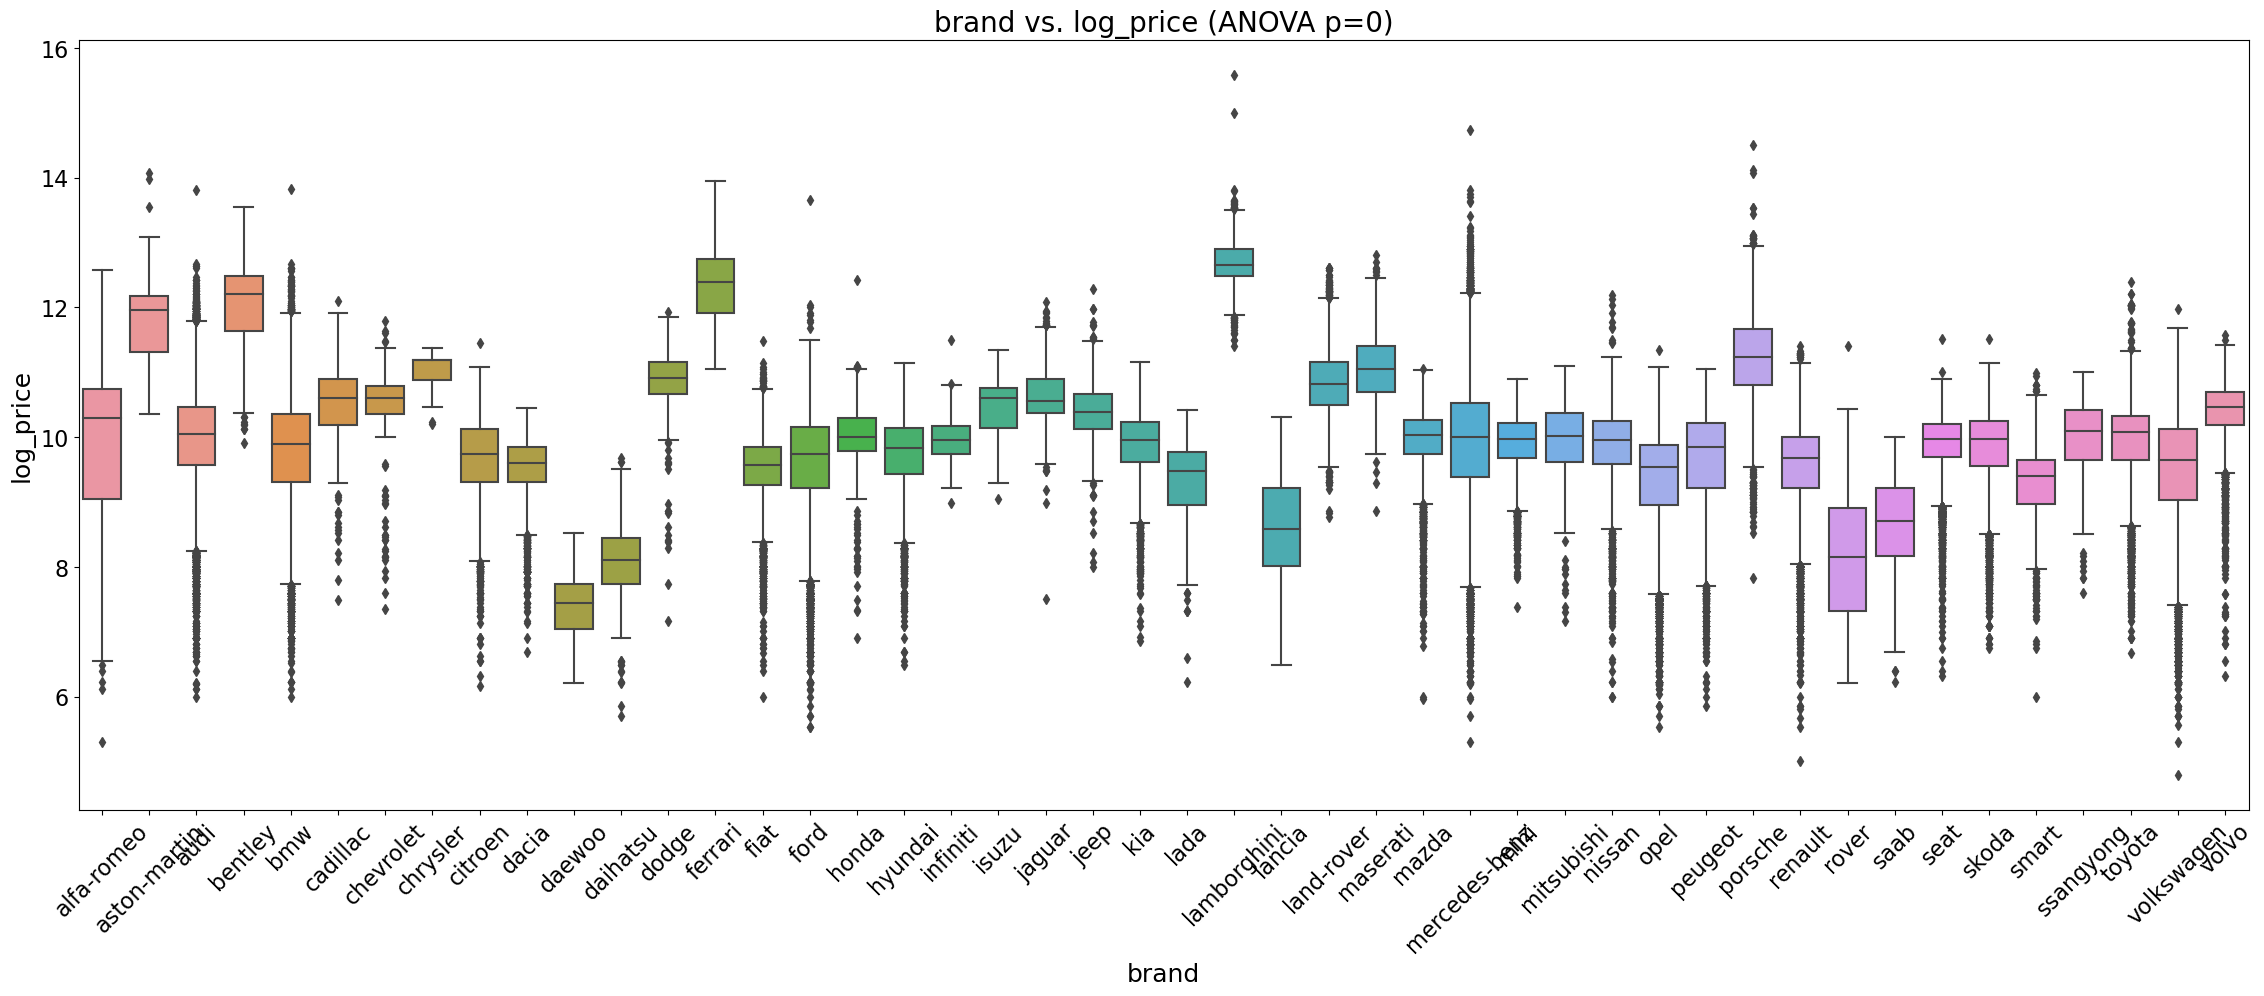

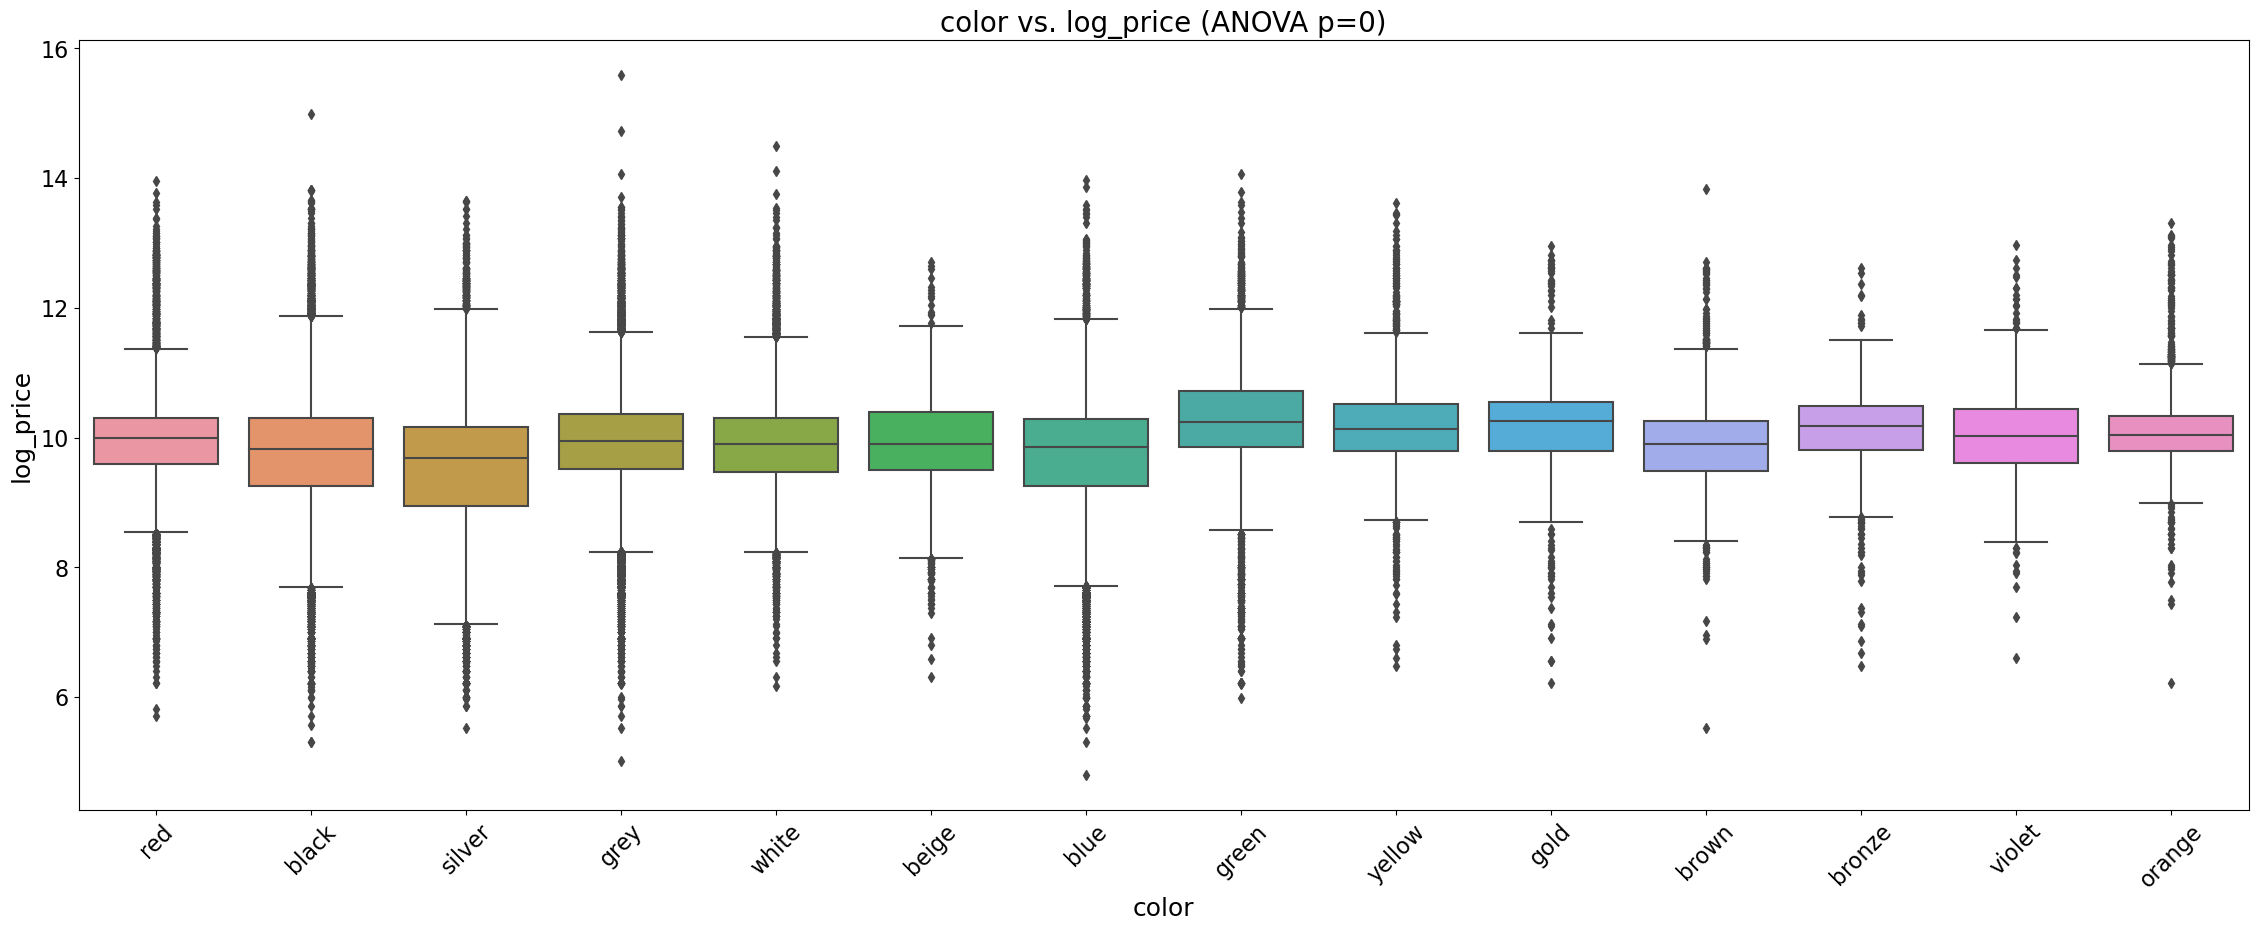

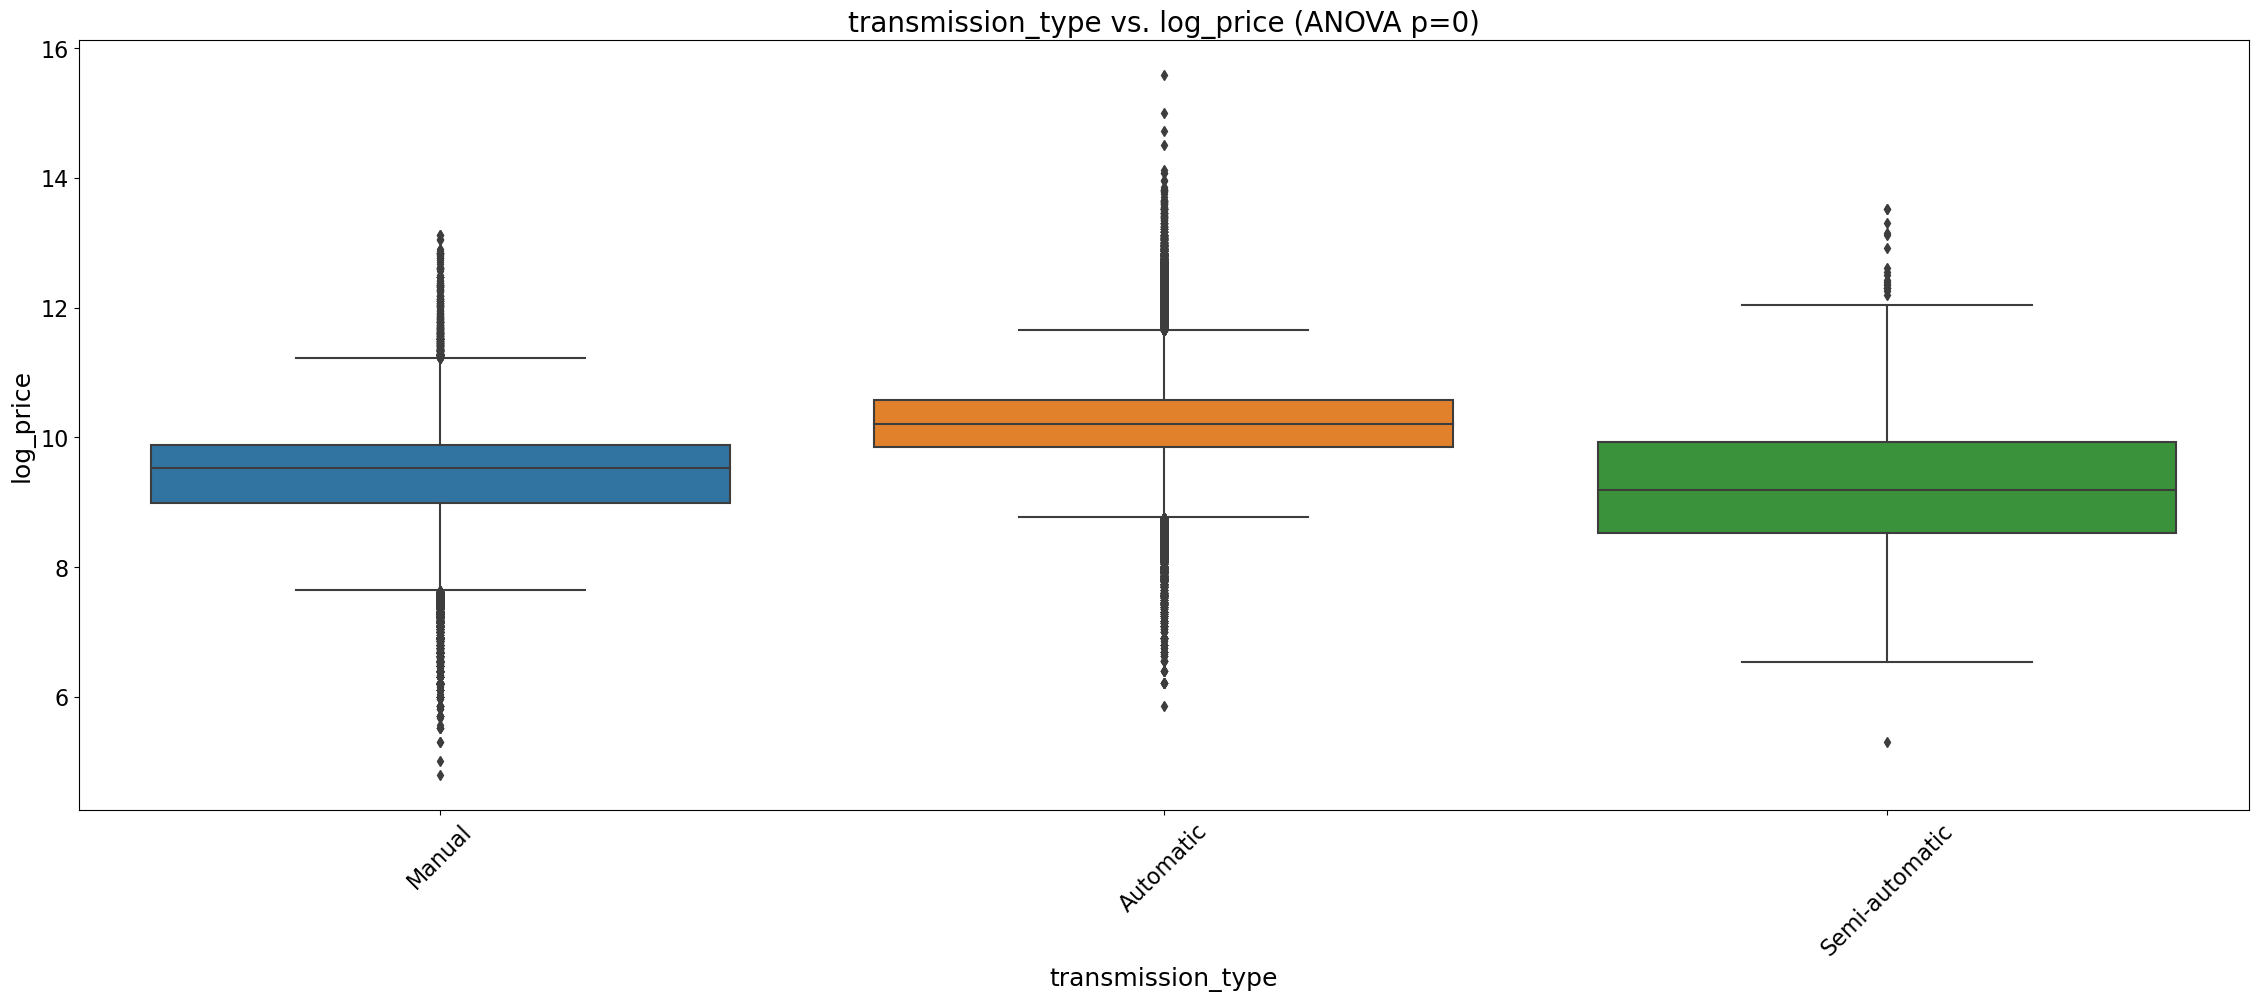

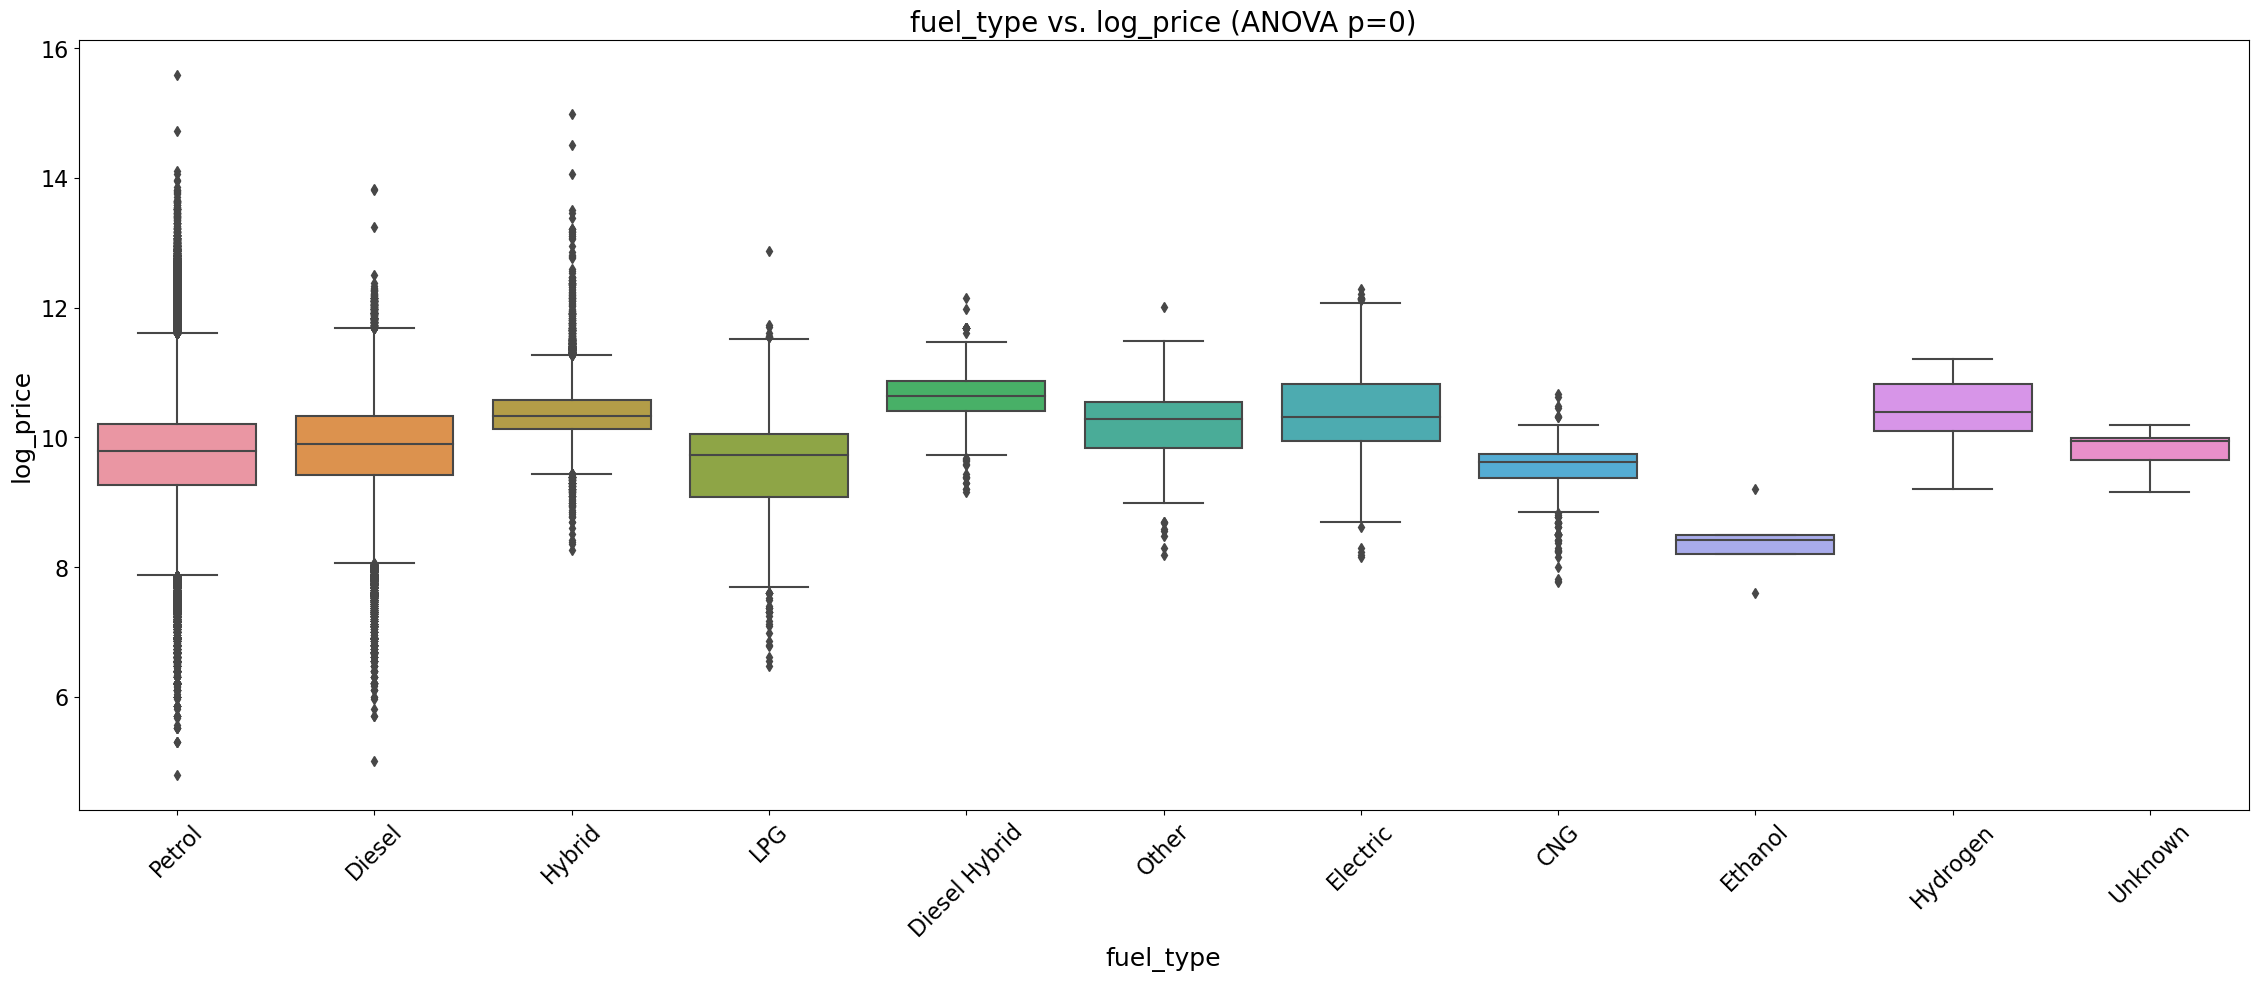

In [59]:
for cat in cat_features:
    if cat == 'model': # zu viele Kategorien
        continue

    plt.figure(figsize=(28,10))
    sns.boxplot(x=cat, y='log_price', data=df)
    plt.title(f'{cat} vs. log_price (ANOVA p={p_value:.3g})')
    plt.xticks(rotation=45)
    plt.show()


### Correlation

- Korrelation zwischen zwei kategorialer Variablen
- Brand und Model korrelieren 100 % (eins davon löschen oder kombiniertes Feature)

In [60]:
import association_metrics as am

df_cat = df.drop(columns=["offer_description"])
df_cat = df_cat.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(df_cat)

cramersv.fit()

,brand,model,color,transmission_type,fuel_type
brand,1.000000,1.000000,0.112717,0.304879,0.205357
model,1.000000,1.000000,0.221026,0.456701,0.520936
color,0.112717,0.221026,1.000000,0.053438,0.047233
transmission_type,0.304879,0.456701,0.053438,1.000000,0.212000
fuel_type,0.205357,0.520936,0.047233,0.212000,1.000000


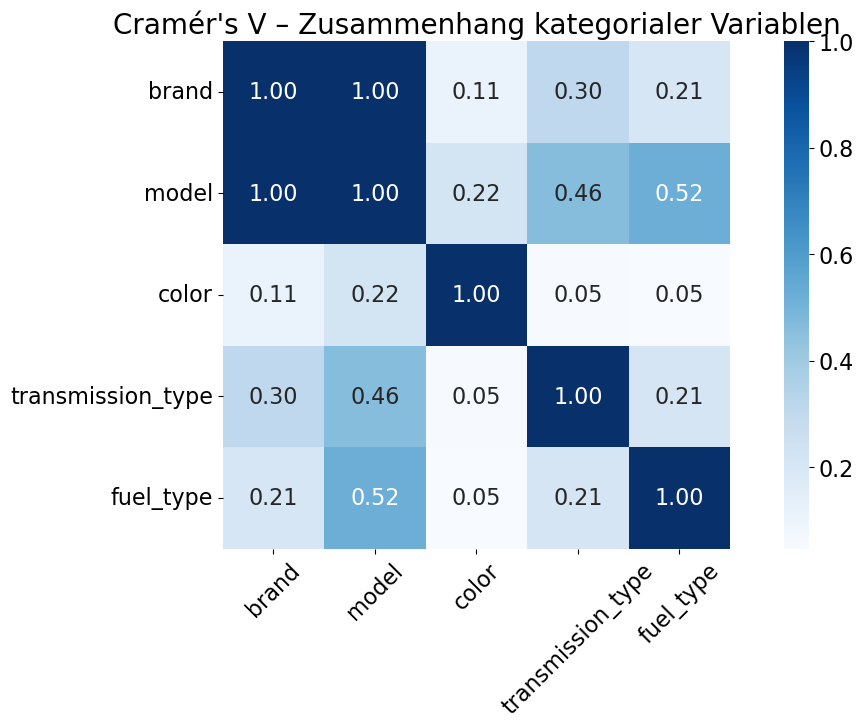

In [61]:
dir(cramersv)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cramersv.matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    square=True,
)

plt.title("Cramér's V – Zusammenhang kategorialer Variablen",fontsize=20)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


* Leistungen sind identisch
* Kraftstoffverbrauch ist identisch



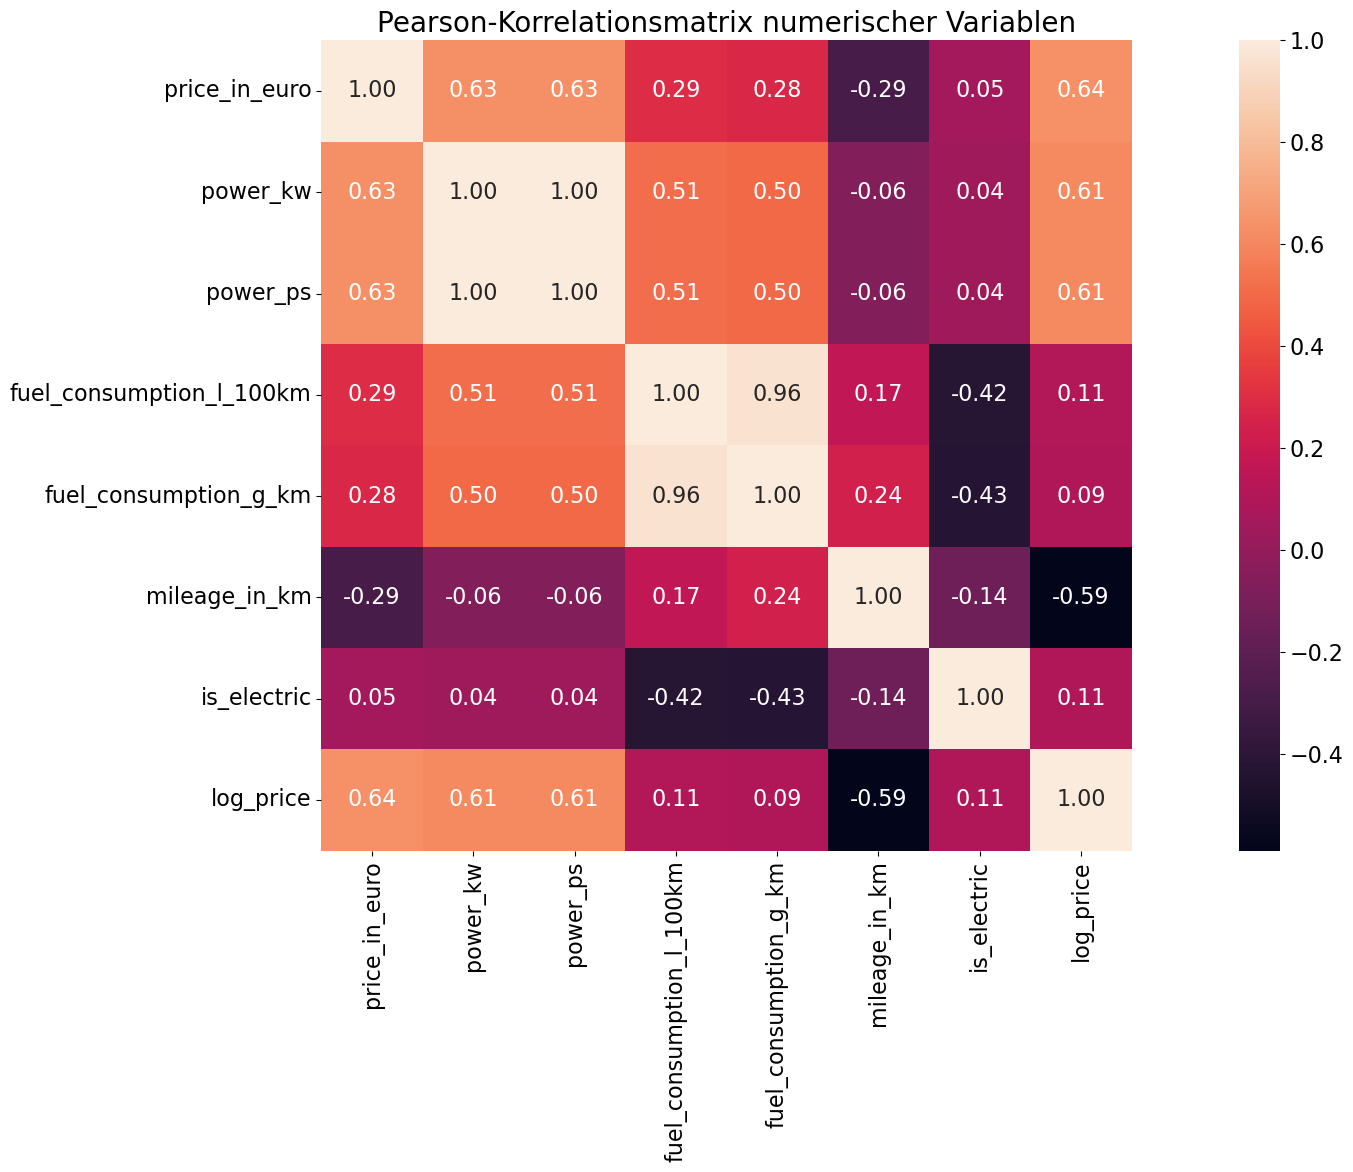

In [62]:
plt.figure(figsize=(22, 12))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True,square=True,fmt=".2f",)

plt.title("Pearson-Korrelationsmatrix numerischer Variablen")
plt.tight_layout()
plt.show()

# 4.Feature Engineering

- Wir löschen die Spalten power_ps, fuel_consumption_g_km und model, da sie zu über 95 Prozent korreliert sind.
- Unsere Zielvariable wird ebenfalls gelöscht, da wir sie in logarithmierter Form weiter betrachten werden.

In [63]:
df_f = df.copy() 
df_f=df_f.drop(columns=["power_ps","fuel_consumption_g_km","model","price_in_euro"])
df_f.head()

,brand,color,registration_date,year,power_kw,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km,offer_description,is_electric,log_price
0,alfa-romeo,red,1995-10-01,1995-01-01,148.0,Manual,Petrol,10.9,160500.0,2.0 V6 TB,False,7.170888
1,alfa-romeo,black,1995-07-01,1995-01-01,110.0,Manual,Petrol,9.5,189500.0,2.0 16V Twin Spark L,False,8.497195
2,alfa-romeo,red,1996-11-01,1996-01-01,132.0,Manual,Petrol,7.2,96127.0,"3.0i Super V6, absoluter Topzustand !",False,9.795401
3,alfa-romeo,red,1996-04-01,1996-01-01,110.0,Manual,Petrol,9.5,47307.0,2.0 16V Twin Spark,False,8.974745
4,alfa-romeo,red,1996-12-01,1996-01-01,110.0,Manual,Petrol,8.8,230000.0,Quadrifoglio,False,8.160804


In [64]:
df_corr = pd.DataFrame({
    'year': df_f['year'].dt.year,
    'reg_year': df_f['registration_date'].dt.year
})

df_corr_table = df_corr.corr()
print(df_corr_table)


          year  reg_year
year       1.0       1.0
reg_year   1.0       1.0


- neues feauture car_age , year und registration_date werden gelöscht

In [65]:
df_f['car_age'] = ((pd.Timestamp('today') - df_f['registration_date']).dt.days / 365.25).round(2)
df_f= df_f.drop(columns=['registration_date',"year"])
df_f.head()


,brand,color,power_kw,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km,offer_description,is_electric,log_price,car_age
0,alfa-romeo,red,148.0,Manual,Petrol,10.9,160500.0,2.0 V6 TB,False,7.170888,30.31
1,alfa-romeo,black,110.0,Manual,Petrol,9.5,189500.0,2.0 16V Twin Spark L,False,8.497195,30.56
2,alfa-romeo,red,132.0,Manual,Petrol,7.2,96127.0,"3.0i Super V6, absoluter Topzustand !",False,9.795401,29.22
3,alfa-romeo,red,110.0,Manual,Petrol,9.5,47307.0,2.0 16V Twin Spark,False,8.974745,29.81
4,alfa-romeo,red,110.0,Manual,Petrol,8.8,230000.0,Quadrifoglio,False,8.160804,29.14


In [66]:
df_corr = pd.DataFrame({
    'car_age': df_f["car_age"],
    'mileage_in_km': df_f['mileage_in_km']
})

df_corr_table = df_corr.corr()
print(df_corr_table)

                car_age  mileage_in_km
car_age        1.000000       0.710707
mileage_in_km  0.710707       1.000000


/Users/arturmeshalkin/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning:

overflow encountered in scalar multiply



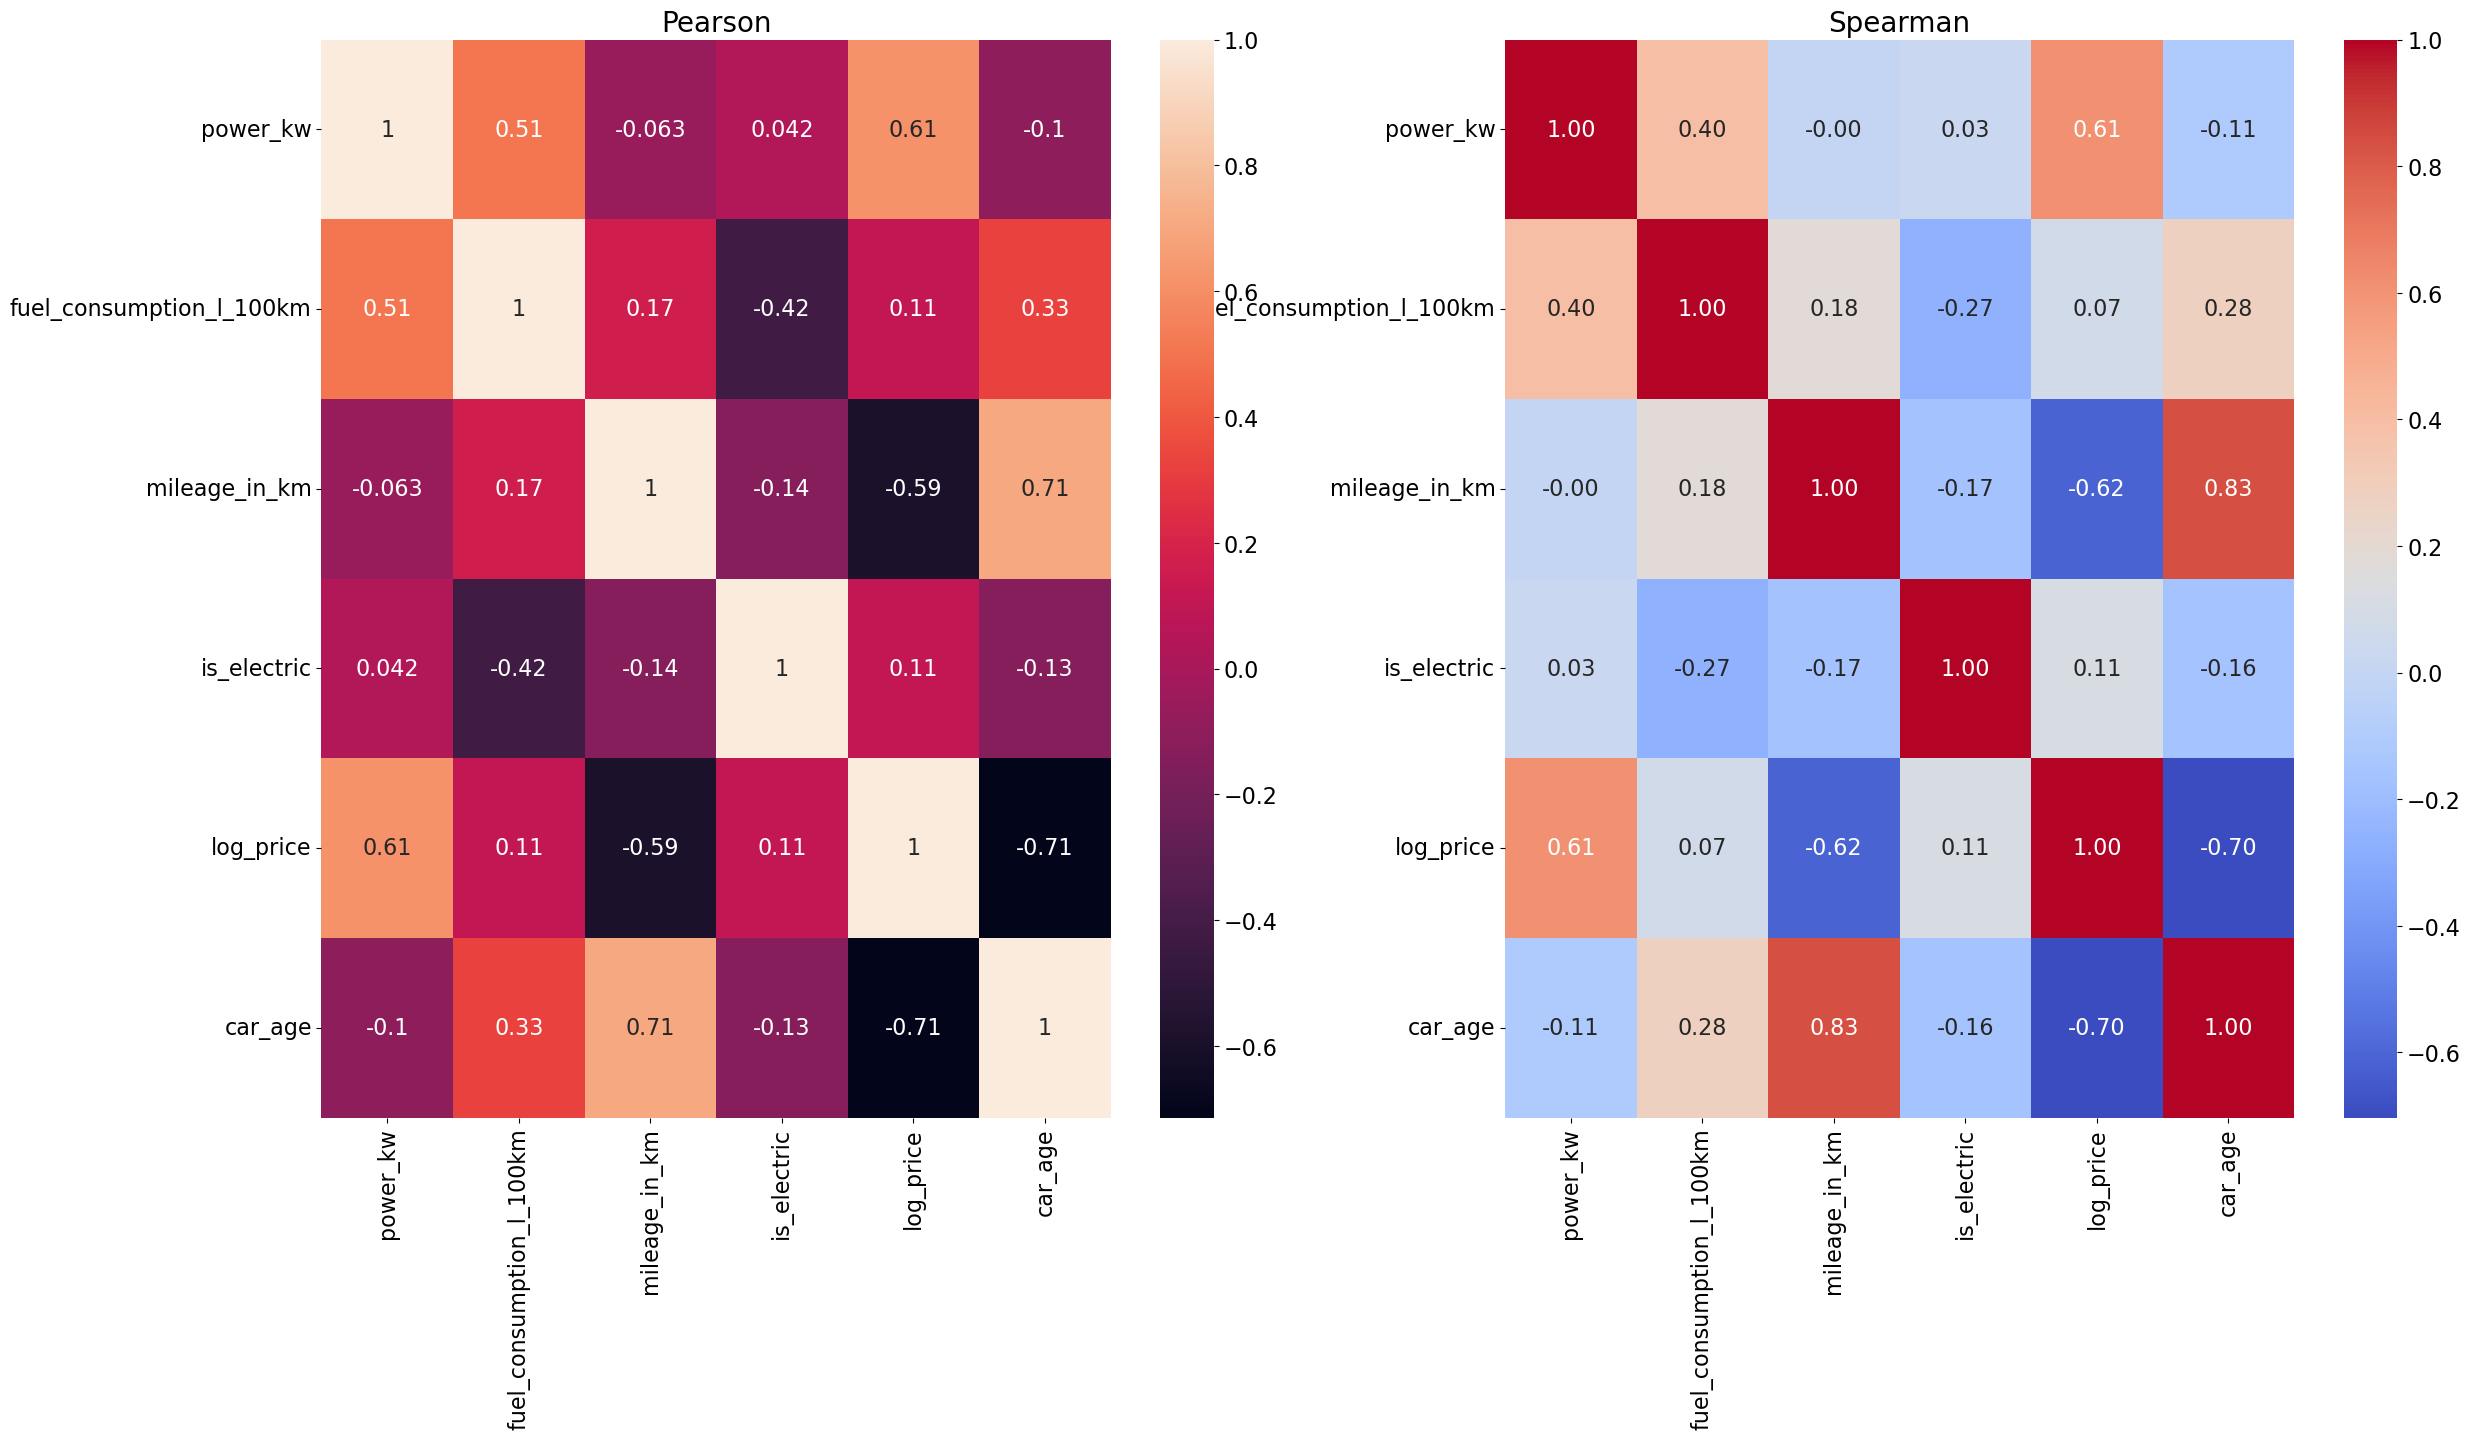

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(28,14))
corr1 = df_f.corr(method='pearson',numeric_only=True)
sns.heatmap(corr1, annot=True,ax=axes[0]);
axes[0].set_title('Pearson')
corr2 = df_f.corr(method='spearman',numeric_only=True)
sns.heatmap(corr2,cmap="coolwarm", annot=True,ax=axes[1],fmt=".2f")
axes[1].set_title('Spearman')
corr3 = df_f.corr(method='kendall',numeric_only=True)

- mileage_in_km und car_age haben starke monotone negative Korrelationen zum Preis,deshalb machen wir eine log Transformation


In [68]:
df_f['log_mileage'] = np.log(df_f['mileage_in_km']+1)
df_f['log_age'] = np.log(df_f['car_age'] + 1)
df_f.drop(columns=['car_age','mileage_in_km'], inplace=True)
df_f.head()

,brand,color,power_kw,transmission_type,fuel_type,fuel_consumption_l_100km,offer_description,is_electric,log_price,log_mileage,log_age
0,alfa-romeo,red,148.0,Manual,Petrol,10.9,2.0 V6 TB,False,7.170888,11.986055,3.443938
1,alfa-romeo,black,110.0,Manual,Petrol,9.5,2.0 16V Twin Spark L,False,8.497195,12.152150,3.451890
2,alfa-romeo,red,132.0,Manual,Petrol,7.2,"3.0i Super V6, absoluter Topzustand !",False,9.795401,11.473436,3.408504
3,alfa-romeo,red,110.0,Manual,Petrol,9.5,2.0 16V Twin Spark,False,8.974745,10.764435,3.427839
4,alfa-romeo,red,110.0,Manual,Petrol,8.8,Quadrifoglio,False,8.160804,12.345839,3.405853


Die Werte unter 2000 in Krafstoffart werden in eine gruppe zussamne gebracht

In [69]:
fuel_counts = df_f['fuel_type'].value_counts()

rare_fuels = fuel_counts[fuel_counts < 2000].index

df_f['fuel_type_grouped'] = df['fuel_type'].replace(rare_fuels, 'Other')

df_f['fuel_type_grouped'].value_counts()
df_f = df_f.drop(columns=['fuel_type'])

In [70]:
df_f['brand_transmission'] = df_f['brand'] + "_" + df_f['transmission_type']

Nach probieren hat es sich gezeigt, dass elektrische Autos doch nicht einfach eretzbar sind. Für diesen Moment lasse ich die Daten weg. Was man danach in Verbesserungsmöglichkeiten betrachten sollte.

In [71]:
df_f = df_f[df_f['is_electric']==0]
df_f.shape
df_f.drop(columns=['is_electric'], inplace=True)
df_f.reset_index(inplace=True, drop=True)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240505 entries, 0 to 240504
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   brand                     240505 non-null  object        
 1   model                     240505 non-null  object        
 2   color                     240505 non-null  object        
 3   registration_date         240505 non-null  datetime64[ns]
 4   year                      240505 non-null  datetime64[ns]
 5   price_in_euro             240505 non-null  float64       
 6   power_kw                  240505 non-null  float64       
 7   power_ps                  240505 non-null  float64       
 8   transmission_type         240505 non-null  object        
 9   fuel_type                 240505 non-null  object        
 10  fuel_consumption_l_100km  240505 non-null  float64       
 11  fuel_consumption_g_km     240505 non-null  float64       
 12  mi

In [73]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234654 entries, 0 to 234653
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     234654 non-null  object 
 1   color                     234654 non-null  object 
 2   power_kw                  234654 non-null  float64
 3   transmission_type         234654 non-null  object 
 4   fuel_consumption_l_100km  234654 non-null  float64
 5   offer_description         234654 non-null  object 
 6   log_price                 234654 non-null  float64
 7   log_mileage               234654 non-null  float64
 8   log_age                   234654 non-null  float64
 9   fuel_type_grouped         234654 non-null  object 
 10  brand_transmission        234654 non-null  object 
dtypes: float64(5), object(6)
memory usage: 19.7+ MB


In [74]:
df_f.to_csv('new_cars.csv', index=False)